# Traction Analytics of News Articles

### Table of Contents

1. Data Preparation
2. Feature Engineering
3. Exploratory Data Analysis
4. Data Labelling
5. Model Building
6. Model Evaluation

### 1. Data Preparation

In [1]:
import pandas as pd
import ast 

pd.set_option('display.max_colwidth', None)

In [2]:
def load_data(filename):
    df = pd.read_csv("data/may_june_data_merged.csv") #.head(100)

    # Selecting Relevent Columms
    df = df[
        [
            "published",
            "headline",
            "summary",
            "link",
            "domain",
            "facebook_interactions",
            "date_extracted",
            "suggested_labels",
        ]
    ]

    # Converting published column to datetime
    df["published"] = pd.to_datetime(df["published"])
    df["date_extracted"] = pd.to_datetime(df["date_extracted"])

    # Extracting theme and index for each article
    df["suggested_labels"] = df["suggested_labels"].apply(lambda x: ast.literal_eval(x))
    df["article_theme"] = df["suggested_labels"].apply(lambda x: x[0].split(" > ")[0])
    df["article_index"] = df["suggested_labels"].apply(lambda x: x[0].split(" > ")[1])
    df = df.drop(columns=["suggested_labels"])

    # Sort articles
    df = df.sort_values(
        by=["headline", "published", "date_extracted"], ascending=[False, True, True]
    ).reset_index(drop=True)
    return df


def create_unique_df(df):
    df_unique = df.drop_duplicates(
        subset=["headline", "published"], keep="first"
    ).reset_index(drop=True)
    # Remove articles with indexes having less than 2 occurences
    df_unique = df_unique.groupby("article_index").filter(lambda x: len(x) > 1)

    return df_unique

In [3]:
df = load_data('data/may_june_data_merged.csv')
df_unique = create_unique_df(df)

### 2. Feature Engineering

In [4]:
from textblob import TextBlob
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\edmun\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

General Feature Engineering

In [5]:
def engineer_features(df_unique):

    # Concat headline and summary
    df_unique['text'] = df_unique['headline'] + ' ' + df_unique['summary']

    # creature a feature for the number of hours since the article of the same article_index was published
    df_unique['hours_since_published'] = df_unique.sort_values(by=['published']).groupby(['article_index'])['published'].diff().dt.total_seconds().div(3600)
    df_unique['hours_since_published'] = df_unique['hours_since_published'].fillna(0)

    # create a feature for day of week published
    df_unique['day_of_week_published'] = df_unique['published'].dt.day_name().map({'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6,'Sunday': 7})

    # Create a featyre for hour of day published
    df_unique['hour_of_day_published'] = df_unique['published'].dt.hour

    # create a feature for number of words in headline
    df_unique['headline_word_count'] = df_unique['headline'].str.split().str.len()

    # create a feature for number of words in summary
    df_unique['summary_word_count'] = df_unique['summary'].str.split().str.len()

    # create a feature for number of words in text
    df_unique['text_word_count'] = df_unique['text'].str.split().str.len()

    # create a feature for number of non-stop words in headline and summary
    stop_words = set(stopwords.words('english'))
    df_unique['headline_non_stop_word_count'] = df_unique['headline'].apply(lambda x: len([word for word in str(x).split() if word.lower() not in stop_words]))
    df_unique['summary_non_stop_word_count'] = df_unique['summary'].apply(lambda x: len([word for word in str(x).split() if word.lower() not in stop_words]))
    df_unique['text_non_stop_word_count'] = df_unique['text'].apply(lambda x: len([word for word in str(x).split() if word.lower() not in stop_words]))

    # create a feature for number of unique words in headline and summary
    df_unique['headline_unique_word_count'] = df_unique['headline'].apply(lambda x: len(set([word for word in str(x).split()])))
    df_unique['summary_unique_word_count'] = df_unique['summary'].apply(lambda x: len(set([word for word in str(x).split()])))
    df_unique['text_unique_word_count'] = df_unique['text'].apply(lambda x: len(set([word for word in str(x).split()])))

    # creature a feature for the sentiment of the headline and summary
    df_unique['headline_sentiment'] = df_unique['headline'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    df_unique['summary_sentiment'] = df_unique['summary'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    df_unique['text_sentiment'] = df_unique['text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

    # create a feature for the subjectivity of the headline and summary
    df_unique['headline_subjectivity'] = df_unique['headline'].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)
    df_unique['summary_subjectivity'] = df_unique['summary'].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)
    df_unique['text_subjectivity'] = df_unique['text'].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)

    # Remove NA rows
    df_unique = df_unique.dropna()

    return df_unique

Web Traffic Data

In [6]:
domain_map = {
    'asiaone': ['asiaone.com'],
    'businesstimes': ['businesstimes.com.sg'],
    'channelnewsasia': ['channelnewsasia.com', 'cnalifestyle.channelnewsasia.com', 'cnaluxury.channelnewsasia.com'],
    'goodyfeed': ['goodyfeed.com'],
    'mothership': ['babelfish.mothership.sg', 'mothership.sg', ],
    'mustsharenews': ['mustsharenews.com'],
    'ricemedia': ['ricemedia.co'],
    'straitstimes': ['straitstimes.com'],
    'stomp': ['stomp.straitstimes.com'],
    'thenewpaper': ['tnp.straitstimes.com'],
    'theonlinecitizen': ['theonlinecitizen.com'],
    'today': ['todayonline.com'],
    'yahoosingapore': ['sg.finance.yahoo.com', 'sg.news.yahoo.com', 'sg.style.yahoo.com'],
    # 'others': ['au.lifestyle.yahoo.com', 'au.news.yahoo.com','coconuts.co','malaysia.news.yahoo.com','public.flourish.studio', 'uk.news.yahoo.com']
}

reverse_domain_map = {}
for key, value in domain_map.items():
    for v in value:
        reverse_domain_map[v] = key

domain_traffic = {
    'asiaone': [4990000,1290000],
    'businesstimes': [1630000, 622688],
    'channelnewsasia': [14760000, 2330000],
    'goodyfeed': [891376, 461731],
    'mothership': [6770000, 1660000],
    'mustsharenews': [2010000, 823526],
    'ricemedia': [148791, 86394],
    'straitstimes': [12310000, 2230000],
    'stomp': [1270000, 427113],
    'theindependent': [2370000, 683818],
    'thenewpaper': [707314, 350734],
    'theonlinecitizen': [657013, 233237],
    'today': [3660000, 1170000],
    'yahoosingapore': [5010000, 561434],
}

traffic_table = pd.DataFrame.from_dict(domain_traffic, orient='index', columns=['mean_monthly_visits', 'mean_monthly_unique_visitors']).reset_index().rename(columns={'index':'domain_group'})

In [7]:
def filter_df(df):
    df = df[df["domain"].isin([i for a in list(domain_map.values()) for i in a])]
    return df

def merge_traffic_table(df_unique):
    df_unique['domain_group'] = df_unique['domain'].map(reverse_domain_map)
    df_unique = df_unique.merge(traffic_table, on='domain_group', how='left')
    return df_unique

In [8]:
df = filter_df(df)

df_unique = engineer_features(df_unique)

df_unfiltererd = df_unique.copy()

df_unique = filter_df(df_unique)
df_unique = merge_traffic_table(df_unique)

### 3. Exploratory Data Analysis

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
sns.set_theme()

Theme and Index Analysis

In [10]:
def plot_themes(df_unique):
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.countplot(y="article_theme", data=df_unique, ax=ax, order=df_unique['article_theme'].value_counts().index)
    ax.set_title("Theme Distribution")
    ax.set_xlabel("Theme")
    ax.set_ylabel("Count")
    plt.show()

def plot_index(df_unique):
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.countplot(y="article_index", data=df_unique, ax=ax, order=df_unique['article_index'].value_counts().index)
    ax.set_title("Index Distribution")
    ax.set_xlabel("Index")
    ax.set_ylabel("Count")
    plt.show()

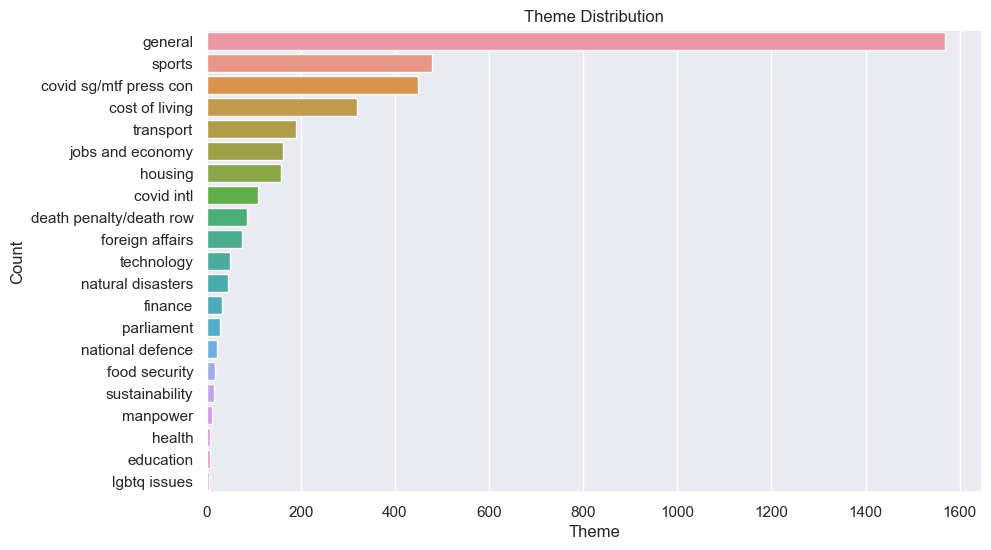

In [11]:
plot_themes(df_unique)

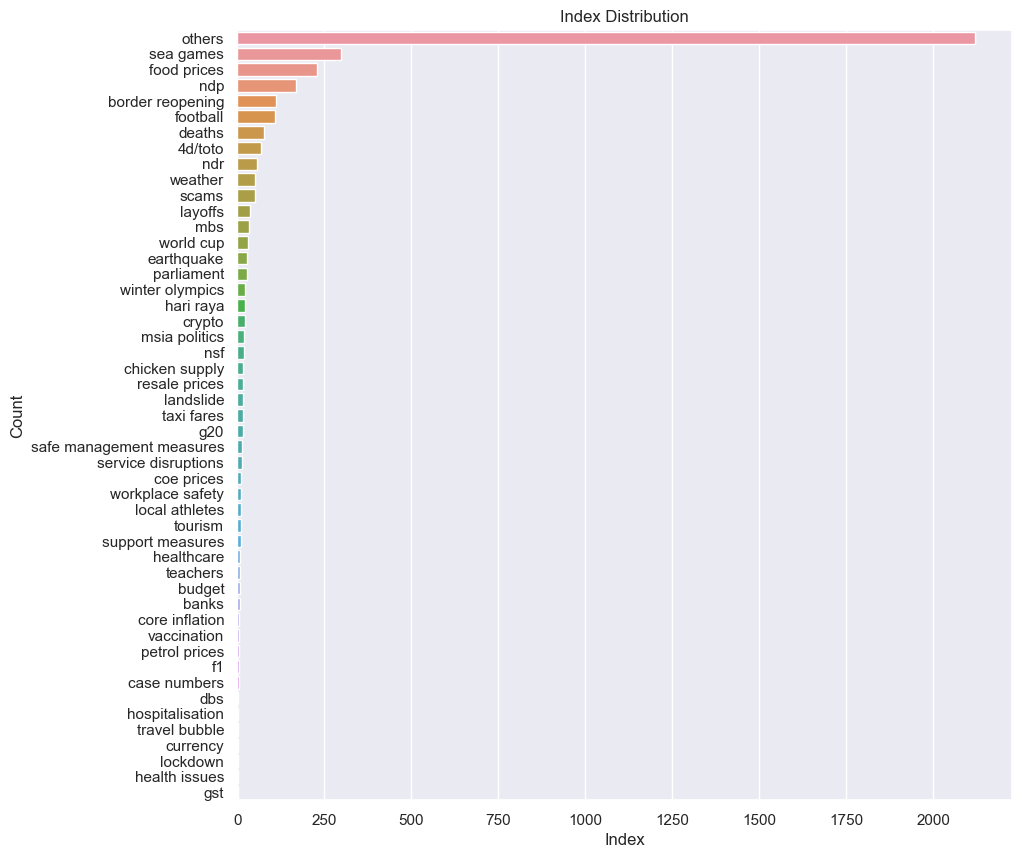

In [12]:
plot_index(df_unique)

Domain Analysis

In [13]:
def plot_domains(df_unique):
    plt.figure(figsize=(10, 6))
    sns.countplot(y='domain', data=df_unique, order=df_unique['domain'].value_counts().index)
    plt.title('Number of articles per domain')
    plt.xlabel('Number of articles')
    plt.ylabel('Domain')
    plt.show()

def plot_domain_group(df_unique):
    plt.figure(figsize=(10, 6))
    sns.countplot(y='domain_group', data=df_unique, order=df_unique['domain_group'].value_counts().index)
    plt.title('Number of articles per domain group')
    plt.xlabel('Number of articles')
    plt.ylabel('Domain Group')
    plt.show()

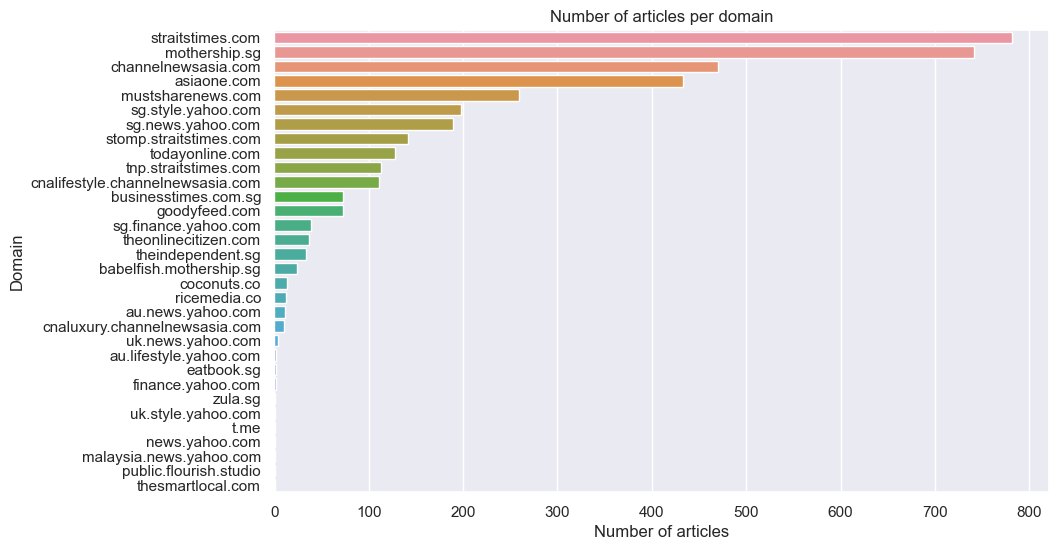

In [14]:
plot_domains(df_unfiltererd)

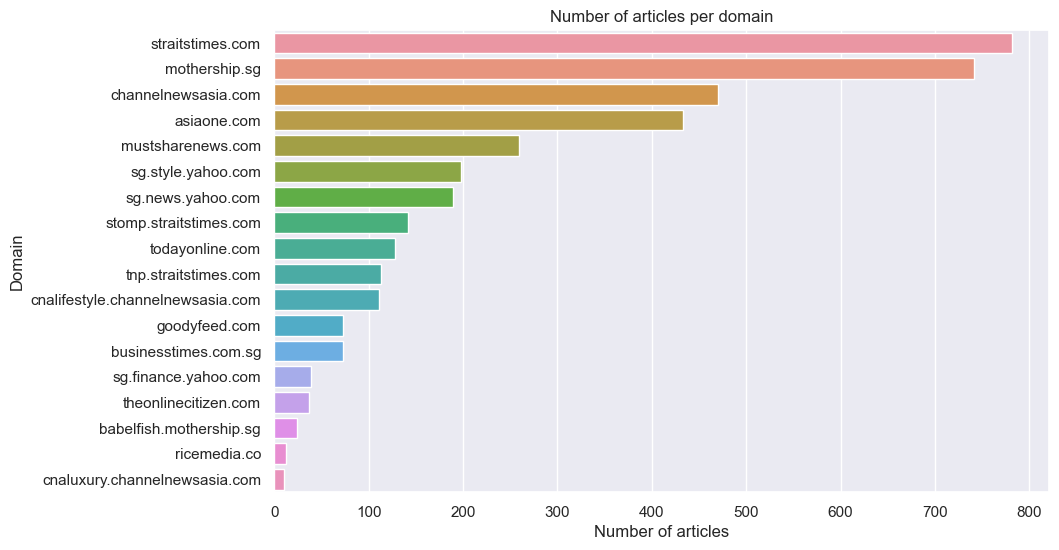

In [15]:
plot_domains(df_unique)

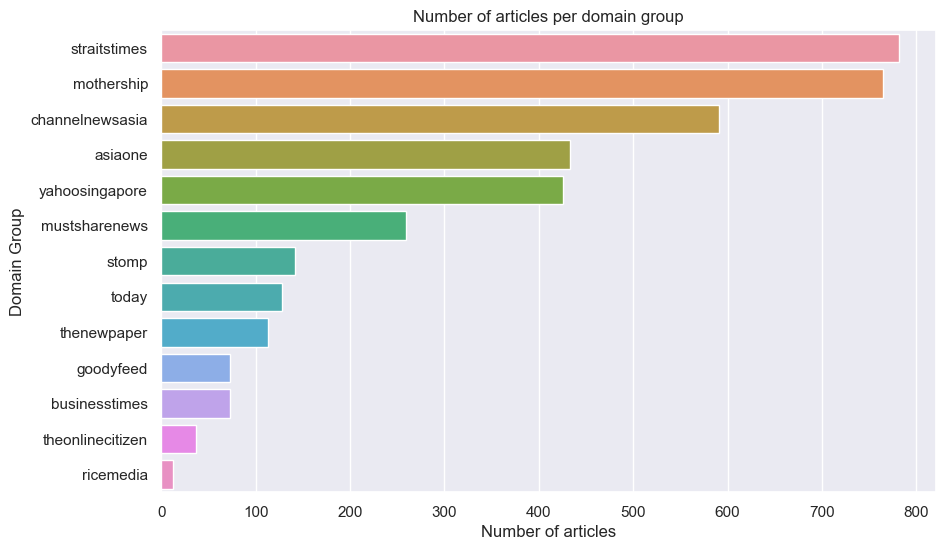

In [16]:
plot_domain_group(df_unique)

In [17]:
def plot_hisplot(df, col, title):
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x=col, bins=100, kde=True)
    plt.title(title)
    plt.show()

def display_sample_higher(df, col, threshold):
    return df[df[col] > threshold][['headline','article_index',col]].head(15).sort_values(by=col, ascending=False)

def display_sample_lower(df, col, threshold):
    return df[df[col] < threshold][['headline','article_index',col]].head(15).sort_values(by=col, ascending=True)


Hours since last article of the same index was published

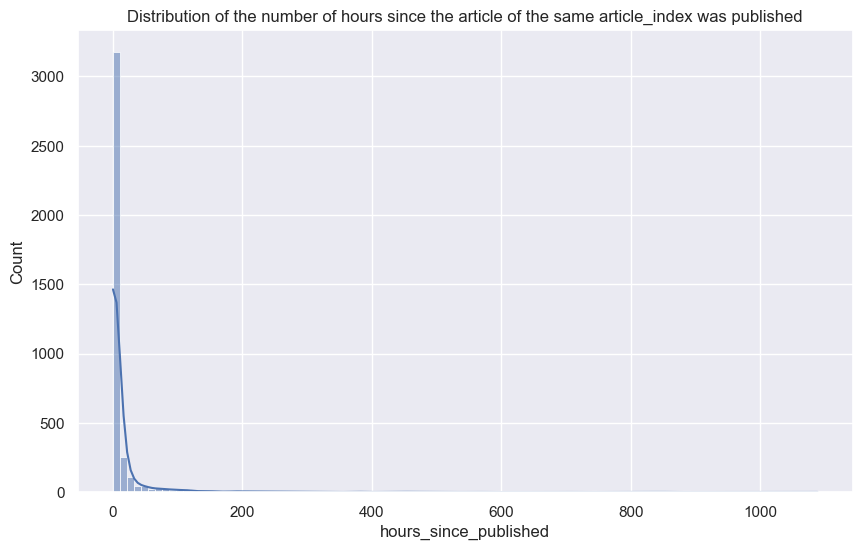

In [18]:
# Plot the distribution of the number of hours since the article of the same article_index was published

plot_hisplot(df_unique, 'hours_since_published', 'Distribution of the number of hours since the article of the same article_index was published')

In [19]:
display_sample_lower(df_unique, 'hours_since_published', 150)

,headline,article_index,hours_since_published
12,â€˜My husband checked for hidden cameras in our home toilet': Voyeur's victim still scarred,others,0.000278
8,"â€˜Sad and inhumane': Yishun resident finds nearly 30 pigeons, most of them dead, lying near HDB blocks",others,0.005833
2,â€˜We cannot stop covering Chinaâ€™ despite challenges faced: journalists at N3Con 2023,others,0.042222
0,â€˜Why is your client smiling?' Judge asks lawyer of voyeur who filmed women nearly 100 times,others,0.083611
9,"â€˜Sad and inhumane': Yishun resident finds nearly 30 pigeons, most of them dead, lying near HDB blocks",others,0.094167
11,â€˜My husband checked for hidden cameras in our home toilet': Voyeur's victim still scarred,others,0.113611
1,"â€˜We will always have your back': 4G team will look after workers in these dark times, says DPM Wong",others,0.131111
13,â€˜Meltingâ€™ Mixue Mascot In Paya Lebar Has Everybody Wondering If Heâ€™s Okay,sea games,0.146111
6,â€˜The Godfather of AI' leaves Google and warns of danger ahead,others,0.202778
5,â€˜The Godfather of AIâ€™ leaves Google and warns of danger ahead,others,0.417778


In [20]:
display_sample_higher(df_unique, 'hours_since_published', 150)

,headline,article_index,hours_since_published
1171,S'pore-born comedian Jocelyn Chia called out by wife of MH370 steward after she jokes about missing flight - Babelfish,travel bubble,1088.068889
213,Whisky lifts spirits of inflation-hit investors,core inflation,696.586667
361,Trust expands product offerings in bid to become S'pore's 4th-largest bank,banks,478.498611
94,"Worker found dead at Tanjong Pagar building site, MOM and BCA order all work to stop",workplace safety,276.111667
44,"Zelenskyy has promised Ukraine will not use F-16 planes to go into Russia, says Biden",msia politics,274.665833
998,Same or not? Local TikTok user reviews UK's version of Singapore's beloved McSpicy,service disruptions,256.538056
752,South Korea experts say more study needed on Japan's nuclear water plan,g20,256.486944
730,"Staff chase after and catch woman, 26, who stole from 2 supermarkets in 1 day",scams,247.687500
496,The tech giants have an interest in AI regulation,layoffs,237.469444
517,The Singaporean Man Engineering F1 Racing Cars From His HDB Flat,f1,215.286111


Number of words in text

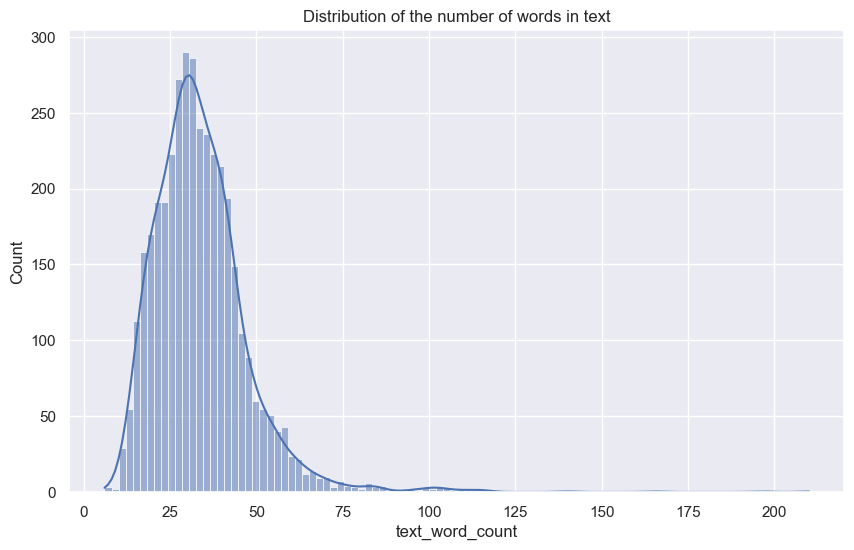

In [21]:
# Plot the distribution of the number of words in text

plot_hisplot(df_unique, 'text_word_count', 'Distribution of the number of words in text')

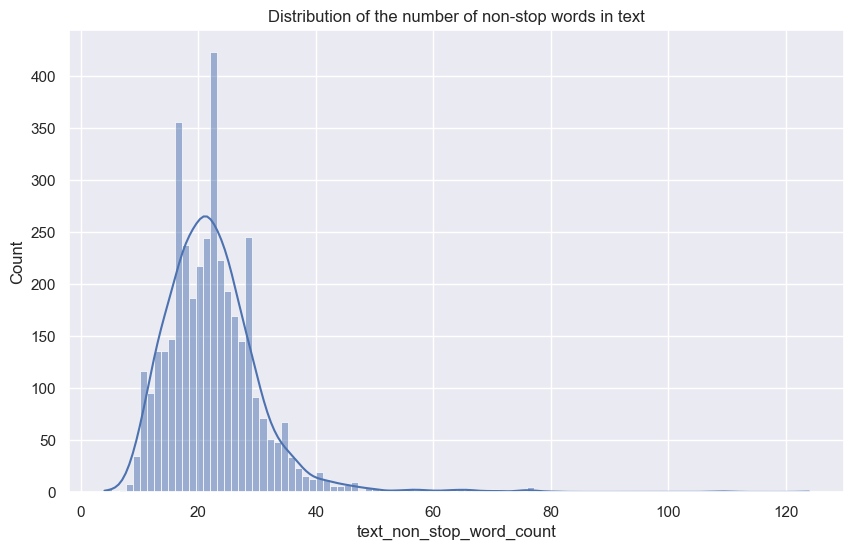

In [22]:
# Plot the distribution of the number of non-stop words in text

plot_hisplot(df_unique, 'text_non_stop_word_count', 'Distribution of the number of non-stop words in text')

Sentiment Analysis

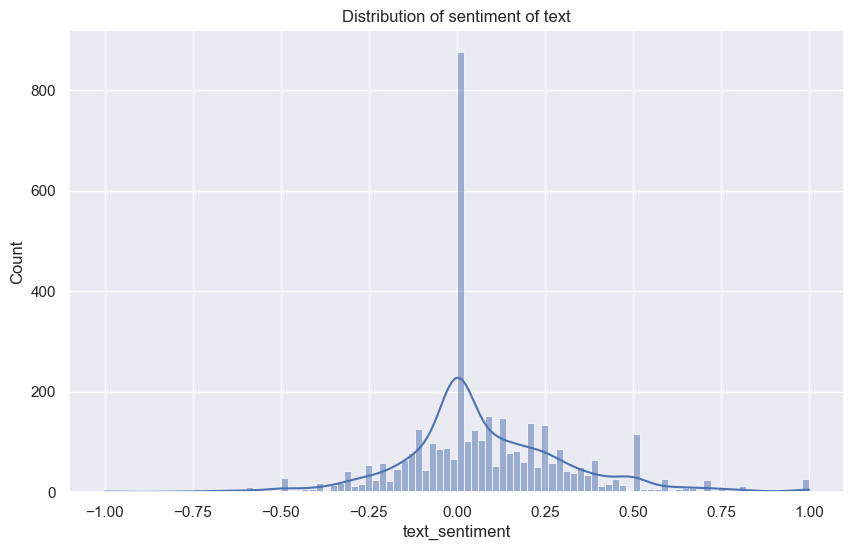

In [23]:
# Plot the distribution of sentiment of text

plot_hisplot(df_unique, 'text_sentiment', 'Distribution of sentiment of text')

In [24]:
display_sample_higher(df_unique, 'text_sentiment', 0.75)

,headline,article_index,text_sentiment
313,Understated pasar malam in Boon Lay has stalls with chuan chuan & stinky tofu till 12 Jun 2023,others,1.000
317,"Uncle Spotted Leisurely Doing Spin Class In Kallang, Looks Like He's Living His Best Life",others,1.000
636,"Sâ€™porean woman 1 of 10 in world to win US$10,000 from YouTuber MrBeast",4d/toto,1.000
649,Sâ€™pore Swimmer Quah Ting Wen Crowned Best Athlete Of Cambodia SEA Games 2023,sea games,1.000
825,Singapore's water polo teams receive 'heartwarming' reception on return from SEA Games,sea games,1.000
851,Singapore swimmer Quah Ting Wen named best athlete of 32nd SEA Games,sea games,1.000
991,Scientists discover a virgin birth in a crocodile,others,1.000
1040,SEA Games: â€˜She said yes!' - Proposal perfect ending to triathlete Bryce Chong's outing,sea games,1.000
1069,SEA Games 2023: Singapore win table tennis team gold with 1st all-local squad since 1973,sea games,1.000
119,Woman â€˜voted off flight by fellow passengersâ€™ after argument,others,0.800


In [25]:
display_sample_lower(df_unique, 'text_sentiment', -0.55)

,headline,article_index,text_sentiment
162,Woman details terrible punishment she suffered in childhood foster home,others,-1.000000
247,We try & rank 10 oat milk brands found in S'pore supermarkets,food prices,-0.800000
999,Sambar deer fawn in S'pore dies after being stranded in canal for days,others,-0.750000
1695,Mercedes driver pleads guilty to drink driving after man dies in horrific multi-vehicle crash in Tampines,others,-0.720000
298,Vegan family requests neighbours to close their windows when cooking meat,chicken supply,-0.714286
206,Why Transformers star Anthony Ramos was shocked by durians,football,-0.700000
1446,Passenger shocked at Singapore Airlinesâ€™ â€˜patheticâ€™ breakfast on Melbourne flight,others,-0.700000
125,Woman threatens to sue Starbucks Malaysia after outlet writes her name as â€˜Babiâ€™,others,-0.666667
795,Singaporeâ€™s forgotten landmarks explained,others,-0.625000
888,Singapore Turf Club employees 'sad and disappointed' about racecourse closure,4d/toto,-0.625000


Subjectivity Analysis

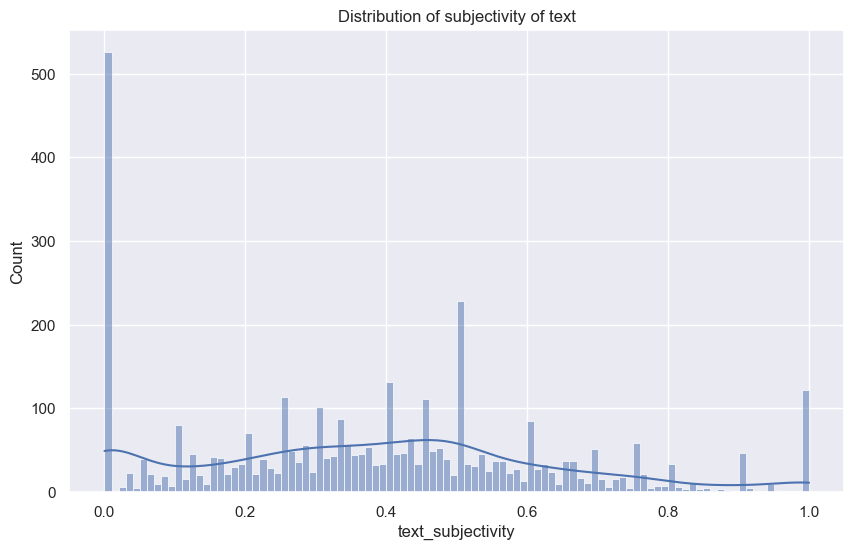

In [26]:
# Plot the distribution of subjectivity of text

plot_hisplot(df_unique, 'text_subjectivity', 'Distribution of subjectivity of text')

In [27]:
display_sample_higher(df_unique, 'text_subjectivity', 0.75)

,headline,article_index,text_subjectivity
99,Wong Lilin responds to criticism of her holding Cristiano Ronaldo's arm,football,1.000000
125,Woman threatens to sue Starbucks Malaysia after outlet writes her name as â€˜Babiâ€™,others,1.000000
162,Woman details terrible punishment she suffered in childhood foster home,others,1.000000
178,"Woman Stands & Waits Only For Sâ€™pore Bus To Drive Off, Asks If She Should've Flagged It",others,1.000000
191,Wife's battle with cancer inspires retiree to make $1m donation,ndp,1.000000
207,Why Tharman's candidacy is a boost for the elected presidency,ndr,1.000000
149,"Woman hangs underwear along corridor: 'Every morning, neighbours have to see her lingerie'",others,0.893750
203,"Why climb Everest? From snow to sand, adventurers are our ambassadors of possibility",landslide,0.875000
20,â€˜I now realise I cannot control everything in my lifeâ€™: A mum on how IVF changed her view of motherhood,others,0.850000
100,Wong Li Lin didn't defend her act of clinging on to Ronaldo's arm. An imposter did. - Babelfish,world cup,0.844444


In [28]:
display_sample_lower(df_unique, 'text_subjectivity', 0.25)

,headline,article_index,text_subjectivity
31,"library@esplanade to close on Jun 30, collections and programmes to move to National Library Building",others,0.000000
37,Zoo otter picks up visitor's dropped iPhone & bashes it against a rock,others,0.000000
44,"Zelenskyy has promised Ukraine will not use F-16 planes to go into Russia, says Biden",msia politics,0.000000
45,"Yusof Ishak Mosque worker jailed for smoking meth & stashing cannabis in ablution room, cubicle & locker",others,0.000000
34,askST: What happens next as Singapore gears up for the upcoming presidential election?,ndr,0.033333
50,Younger badminton players to carry Singaporeâ€™s hopes in SEA Games singles events,sea games,0.033333
65,You can now lock your chats on WhatsApp,safe management measures,0.100000
38,"Zoe Tay, Fann Wong head overseas for June school holidays",ndp,0.125000
30,"library@esplanade to close on June 30, collections and programmes to move to National Library Building",others,0.200000
59,YouTuber who staged plane crash faces up to 20 years jail: US officials,others,0.200000


Time of Posting Analysis

In [29]:
def agg_post_count_by_time(df_unique, agg_col, top_n=2):
    return (
        df_unique.groupby([agg_col, "domain_group"])
        .agg({"article_index": "count"})
        .reset_index()
        .sort_values(by=[agg_col, "article_index"], ascending=False)
        .groupby(agg_col)
        .head(top_n)
        .rename(columns={"article_index": "count"})
        .sort_values(by=[agg_col, 'count'], ascending=[True, False])
        .reset_index(drop=True)
    )

def plot_post_count_by_time(df_unique, agg_col, top_n=2):
    df = agg_post_count_by_time(df_unique, agg_col, top_n)
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x=agg_col, y="count", hue="domain_group")
    plt.title(f"Top {top_n} domains by {agg_col}")
    plt.show()

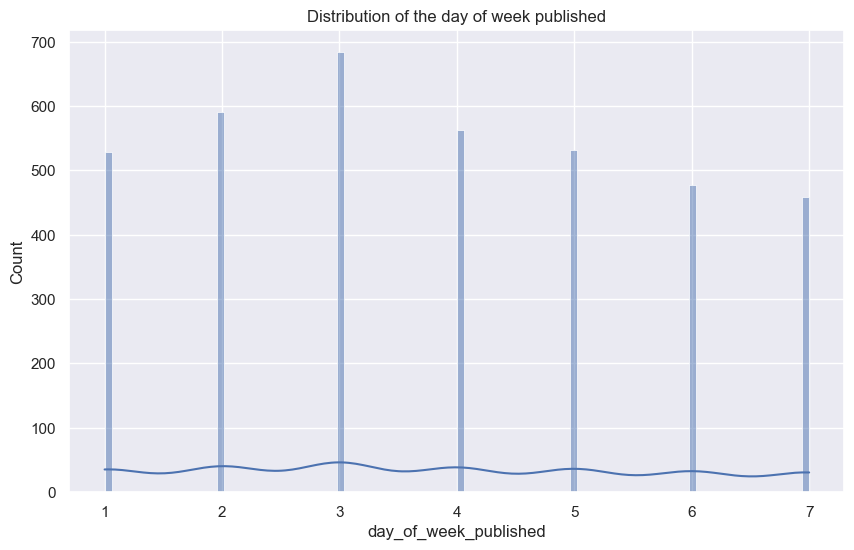

In [30]:
# Plot the distribution of the day of week published

plot_hisplot(df_unique, 'day_of_week_published', 'Distribution of the day of week published')

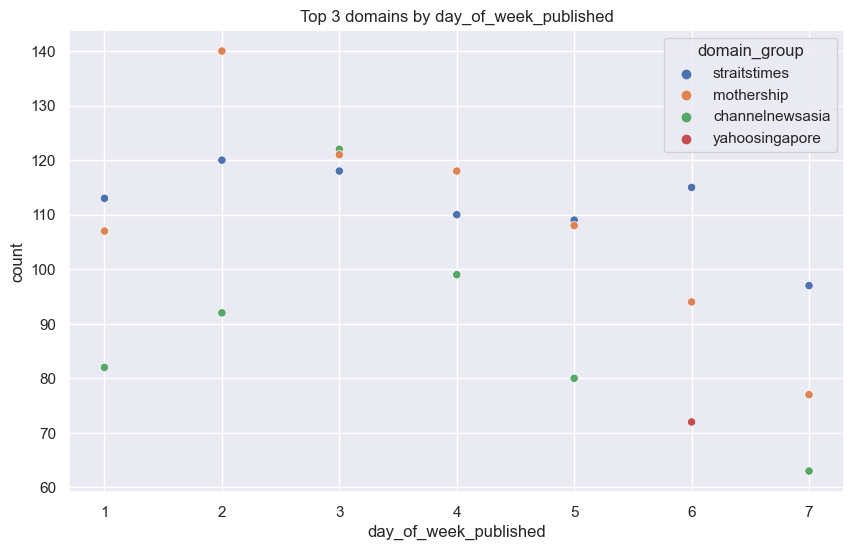

In [31]:
# Calculate on each day of the week, the domain_group with the highest mean number of articles published

plot_post_count_by_time(df_unique, "day_of_week_published", top_n=3)

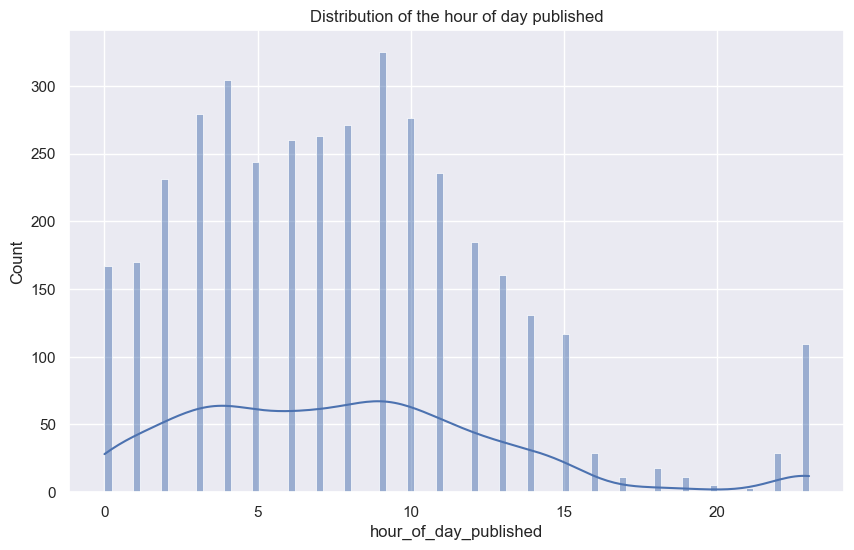

In [32]:
# Plot the distribution of the hour of day published

plot_hisplot(df_unique, 'hour_of_day_published', 'Distribution of the hour of day published')

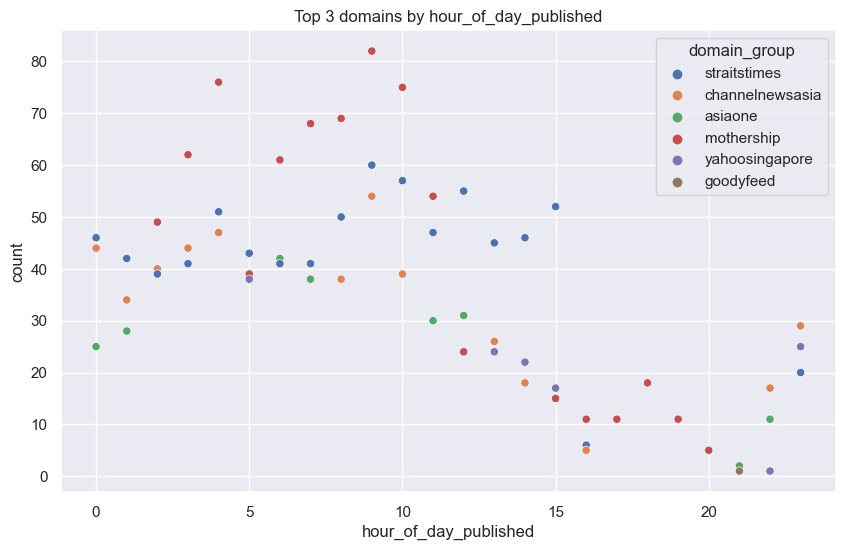

In [33]:
# Calculate on each hour of the day, the domain_group with the highest mean number of articles published

plot_post_count_by_time(df_unique, "hour_of_day_published", top_n=3)


### 4. Data Labelling

In [34]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, QuantileTransformer


In [35]:
GRD_THRESHOLD_UPPER = 1
GRD_THRESHOLD_LOWER = -1
VAL_ARR_THRESHOLD_UPPER = 1
VAL_ARR_THRESHOLD_LOWER = -1

In [36]:
def cal_article_mean_and_gradient(val_array):
    val_array = np.asarray(val_array)
    mean = np.mean(val_array)
    val_array = np.nan_to_num(val_array)
    model = LinearRegression()
    model.fit(np.arange(len(val_array)).reshape(-1, 1), val_array)
    gradient = model.coef_[0]
    return mean, gradient

def agg_mean_and_gradient(df):
    df_agg = df.groupby('link')['facebook_interactions'].agg(cal_article_mean_and_gradient).reset_index()
    return df_agg

def merge_labels(df_unique, df_agg):
    df_labelled = df_unique.merge(df_agg, on='link', how='left')
    df_labelled = df_labelled.rename(columns={'facebook_interactions_x': 'facebook_interactions', 'facebook_interactions_y': 'mean_and_gradient'})
    df_labelled['mean'] = df_labelled['mean_and_gradient'].apply(lambda x: x[0])
    df_labelled['gradient'] = df_labelled['mean_and_gradient'].apply(lambda x: x[1])
    df_labelled.drop(columns=['mean_and_gradient'], inplace=True)
    df_labelled['gradient'] = df_labelled['gradient'].apply(lambda x: 0 if x < 0 else x)
    return df_labelled

def normalise_mean_and_gradient(df_labelled):
    df_labelled['mean_s_scaled'] = StandardScaler().fit_transform(df_labelled[['mean']])
    df_labelled['gradient_s_scaled'] = StandardScaler().fit_transform(df_labelled[['gradient']])

    df_labelled['mean_mm_scaled'] = MinMaxScaler().fit_transform(df_labelled[['mean']])
    df_labelled['gradient_mm_scaled'] = MinMaxScaler().fit_transform(df_labelled[['gradient']])

    df_labelled['mean_r_scaled'] = RobustScaler().fit_transform(df_labelled[['mean']])
    df_labelled['gradient_r_scaled'] = RobustScaler().fit_transform(df_labelled[['gradient']])

    df_labelled['mean_pt_scaled'] = PowerTransformer().fit_transform(df_labelled[['mean']])
    df_labelled['gradient_pt_scaled'] = PowerTransformer().fit_transform(df_labelled[['gradient']])

    df_labelled['mean_qt_scaled'] = QuantileTransformer().fit_transform(df_labelled[['mean']])
    df_labelled['gradient_qt_scaled'] = QuantileTransformer().fit_transform(df_labelled[['gradient']])

    df_labelled['mean_log'] = np.log(df_labelled['mean'])
    df_labelled['gradient_log'] = np.log(df_labelled['gradient'])
    return df_labelled

def plot_gradient(df_labelled):
    fig, ax = plt.subplots(1, 7, figsize=(35, 5))
    sns.histplot(data=df_labelled, x='gradient', bins=100, kde=True, ax=ax[0])
    sns.histplot(data=df_labelled, x='gradient_s_scaled', bins=100, kde=True, ax=ax[1])
    sns.histplot(data=df_labelled, x='gradient_mm_scaled', bins=100, kde=True, ax=ax[2])
    sns.histplot(data=df_labelled, x='gradient_r_scaled', bins=100, kde=True, ax=ax[3])
    sns.histplot(data=df_labelled, x='gradient_pt_scaled', bins=100, kde=True, ax=ax[4])
    sns.histplot(data=df_labelled, x='gradient_qt_scaled', bins=100, kde=True, ax=ax[5])
    sns.histplot(data=df_labelled, x='gradient_log', bins=100, kde=True, ax=ax[6])
    plt.show()

def plot_mean(df_labelled):
    fig, ax = plt.subplots(1, 7, figsize=(35,5))
    sns.histplot(data=df_labelled, x='mean', bins=100, kde=True, ax=ax[0])
    sns.histplot(data=df_labelled, x='mean_s_scaled', bins=100, kde=True, ax=ax[1])
    sns.histplot(data=df_labelled, x='mean_mm_scaled', bins=100, kde=True, ax=ax[2])
    sns.histplot(data=df_labelled, x='mean_r_scaled', bins=100, kde=True, ax=ax[3])
    sns.histplot(data=df_labelled, x='mean_pt_scaled', bins=100, kde=True, ax=ax[4])
    sns.histplot(data=df_labelled, x='mean_qt_scaled', bins=100, kde=True, ax=ax[5])
    sns.histplot(data=df_labelled, x='mean_log', bins=100, kde=True, ax=ax[6])
    plt.show()

def get_label(row, colums):
    gradient_index = colums.index('gradient_pt_scaled')
    mean_index = colums.index('mean_pt_scaled')

    if row[gradient_index] > GRD_THRESHOLD_UPPER or row[mean_index] > VAL_ARR_THRESHOLD_UPPER:
        return "trending"
    
    elif row[gradient_index] < GRD_THRESHOLD_LOWER or row[mean_index] < VAL_ARR_THRESHOLD_LOWER:
        return "diminishing"
    
    else:
        return "neutral"
    
def map_labels_to_numertical(df_labelled):
    label_mapper = {'trending': 2, 'diminishing': 0, 'neutral': 1}
    df_labelled['label'] = df_labelled['label'].map(label_mapper)
    return df_labelled
    
def plot_labels(df_labelled):
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df_labelled, x='label')
    plt.title('Distribution of Target Variable')
    plt.xlabel('Target')
    plt.ylabel('Count')
    plt.show()

def merge_labels_to_main(df_labelled, df):
    df_combined = df.merge(df_labelled[['link', 'label']], on='link', how='left')
    return df_combined

def get_article_activity_by_day(df_labelled, df):
    df_combined = df.merge(df_labelled[['link', 'label']], on='link', how='left')
    unique_articles = df_combined['link'].unique()
    activity_df = pd.DataFrame()

    for article in unique_articles:
        df_slice = df_combined[df_combined['link'] == article].reset_index(drop=True)
        df_slice = df_slice.reset_index().rename(columns={'index': 'day'})
        df_slice['day'] = df_slice['day'] + 1
        activity_df = activity_df.append(df_slice)

    return activity_df
    
def plot_activities(activity_df):
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=activity_df, x='day', y='facebook_interactions', hue='label')
    plt.title('Facebook Interactions over Days')
    plt.xlabel('Day')
    plt.ylabel('Facebook Interactions')
    plt.show()



In [37]:
df_agg = agg_mean_and_gradient(df)
df_labelled = merge_labels(df_unique, df_agg)
df_labelled = normalise_mean_and_gradient(df_labelled)
df_labelled['label'] = df_labelled.apply(lambda x: get_label(x, list(df_labelled.columns)), axis=1)

e:\Dropbox\Internships\GovTech\Codebase\news_matching\venv\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


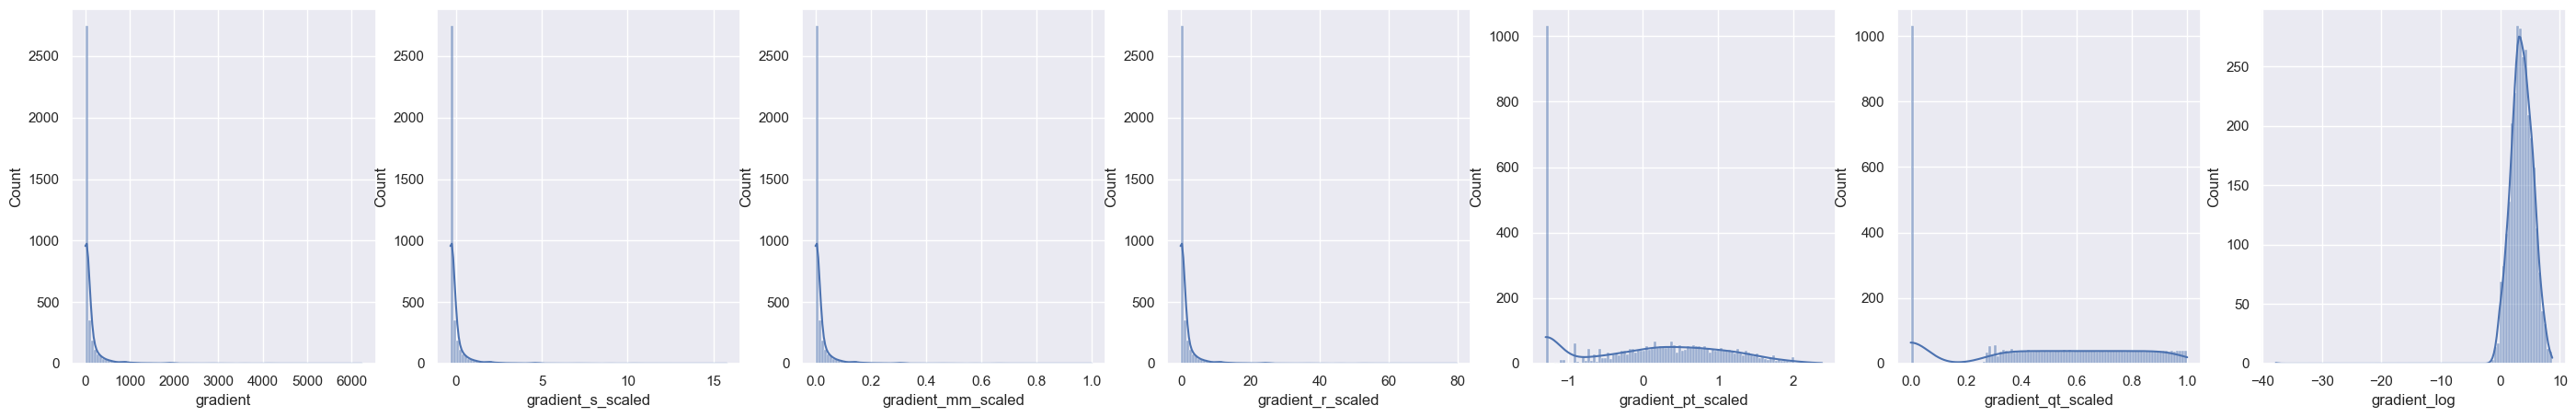

In [38]:
plot_gradient(df_labelled)

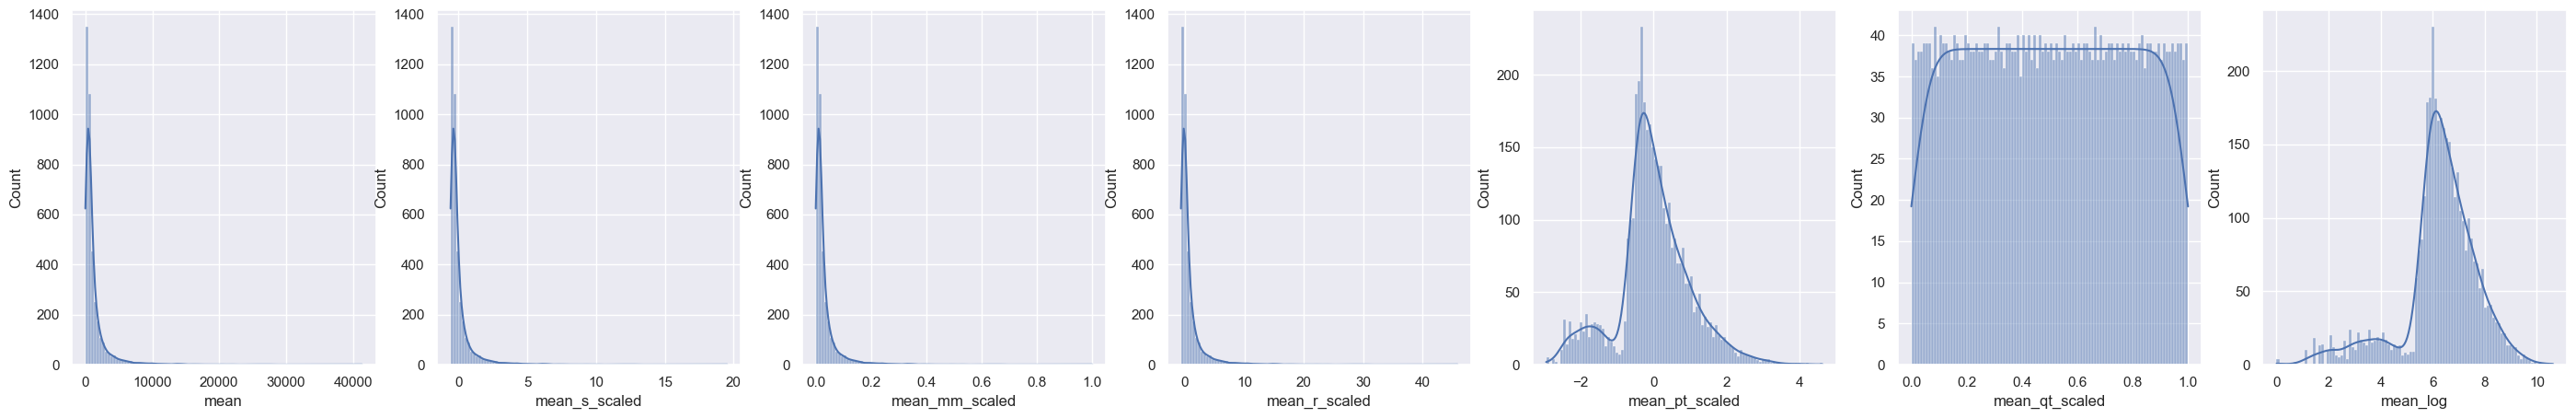

In [39]:
plot_mean(df_labelled)

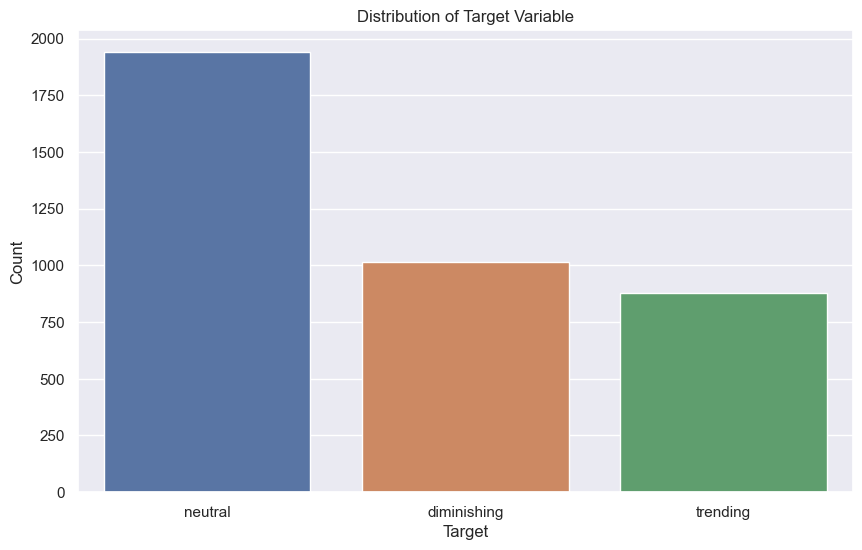

In [40]:
plot_labels(df_labelled)

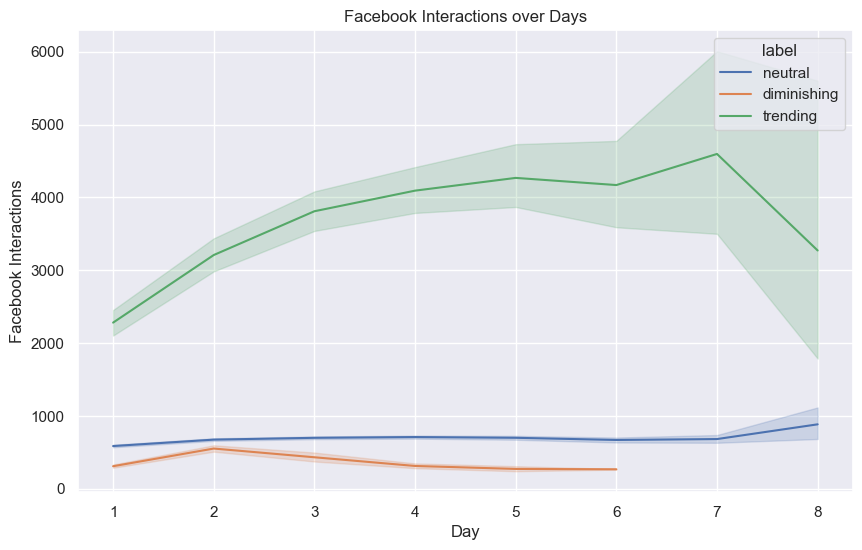

In [41]:
activity_df = get_article_activity_by_day(df_labelled, df)
plot_activities(activity_df)

In [42]:
df_labelled = map_labels_to_numertical(df_labelled)

Index Traction by Aggregation (Majority Weighted Voting)

In [43]:
def get_index_aggregated_labels(df_labelled, col_name):
    df_agg = df_labelled.copy()
    df_agg[f'{col_name}_d'] = df_agg[col_name].apply(lambda x: x)
    df_agg = pd.get_dummies(df_agg, columns=[f'{col_name}_d'])
    dummy_label_cols = [col for col in df_agg.columns if f'{col_name}_d' in col]

    # Assuming equal weighted voting
    df_agg["vote_weights"] = 1

    for col in dummy_label_cols:
        df_agg[col] = df_agg[col] * df_agg['vote_weights']

    df_agg = df_agg.groupby('article_index')[dummy_label_cols].sum().idxmax(axis=1).reset_index().rename(columns={0: 'label'})
    df_agg['label'] = df_agg[col_name].apply(lambda x: int(x[-1]))
    return df_agg.sort_values(by='label', ascending=False).reset_index(drop=True)


In [44]:
get_index_aggregated_labels(df_labelled, 'label')

,article_index,label
0,local athletes,2
1,hari raya,2
2,landslide,1
3,lockdown,1
4,mbs,1
5,msia politics,1
6,ndp,1
7,nsf,1
8,others,1
9,resale prices,1


### 5. Model Building

In [45]:
from datasets import load_dataset
from sentence_transformers.losses import CosineSimilarityLoss
from setfit import SetFitModel, SetFitTrainer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

e:\Dropbox\Internships\GovTech\Codebase\news_matching\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [46]:
RESULTS_STORE = {}

In [47]:
def display_results_store_article():
    df_combined_results = pd.DataFrame()
    for key, value in RESULTS_STORE.items():
        results_key = pd.DataFrame(RESULTS_STORE[key])
        results_key.drop(columns='index_level', inplace=True)
        results_key.rename(columns={'article_level': f'{key}'}, inplace=True)
        df_combined_results = pd.concat([df_combined_results, results_key], axis=1)

    return df_combined_results

def display_results_store_index():
    df_combined_results = pd.DataFrame()
    for key, value in RESULTS_STORE.items():
        results_key = pd.DataFrame(RESULTS_STORE[key])
        results_key.drop(columns='article_level', inplace=True)
        results_key.rename(columns={'index_level': f'{key}'}, inplace=True)
        df_combined_results = pd.concat([df_combined_results, results_key], axis=1)

    return df_combined_results

def evaluate_predictions(test_y, pred_y):
    # macro
    acc = accuracy_score(test_y, pred_y)
    precision = precision_score(test_y, pred_y, average="macro")
    recall = recall_score(test_y, pred_y, average="macro")
    f1 = f1_score(test_y, pred_y, average="macro")

    # construct a dataframe to store the evaluation metrics
    df_eval = pd.DataFrame(
        {"accuracy": [acc], "precision": [precision], "recall": [recall], "f1": [f1]}
    )
    df_eval = df_eval.round(3)
    return df_eval.T.rename(columns={0: "macro"})


def get_predictions_agg(test_dataset, pred_y, weighted=False):
    if not isinstance(test_dataset, pd.DataFrame):
        test_dataset_merge = test_dataset.to_pandas()
    else:
        test_dataset_merge = test_dataset.copy()
    test_dataset_merge["pred_y"] = pred_y

    if weighted:
        # convert label to one-hot encoding
        test_dataset_merge["label_d"] = test_dataset_merge["label"].apply(lambda x: x)
        test_dataset_merge["pred_y_d"] = test_dataset_merge["pred_y"].apply(lambda x: x)
        test_dataset_merge = pd.get_dummies(test_dataset_merge, columns=["label_d"])
        test_dataset_merge = pd.get_dummies(test_dataset_merge, columns=["pred_y_d"])

        dummy_label_cols = [
            col for col in test_dataset_merge.columns if "label_d" in col
        ]
        dummy_pred_cols = [
            col for col in test_dataset_merge.columns if "pred_y_d" in col
        ]

        test_dataset_merge["vote_weights"] = (
            1 / test_dataset_merge["hours_since_published"]
        )

        # weighted voting
        for col in dummy_label_cols:
            test_dataset_merge[col] = (
                test_dataset_merge[col] * test_dataset_merge["vote_weights"]
            )

        for col in dummy_pred_cols:
            test_dataset_merge[col] = (
                test_dataset_merge[col] * test_dataset_merge["vote_weights"]
            )

        # aggregate each article_index by votes and return the label with the highest votes
        test_dataset_agg = (
            test_dataset_merge.groupby("article_index")[dummy_label_cols]
            .sum()
            .idxmax(axis=1)
            .reset_index()
            .rename(columns={0: "label"})
        )
        pred_agg = (
            test_dataset_merge.groupby("article_index")[dummy_pred_cols]
            .sum()
            .idxmax(axis=1)
            .reset_index()
            .rename(columns={0: "label"})
        )

        # Convert back to integer
        test_dataset_agg["label"] = test_dataset_agg["label"].apply(
            lambda x: int(x[-1])
        )
        pred_agg["pred_y"] = pred_agg["label"].apply(lambda x: int(x[-1]))

    else:
        test_dataset_agg = (
            test_dataset_merge.groupby("article_index")["label"]
            .agg(lambda x: x.value_counts().sort_values(ascending=False).index[0])
            .reset_index()
        )
        pred_agg = (
            test_dataset_merge.groupby("article_index")["pred_y"]
            .agg(lambda x: x.value_counts().sort_values(ascending=False).index[0])
            .reset_index()
        )
    # return test_dataset_agg, pred_agg
    return test_dataset_agg["label"], pred_agg["pred_y"]


def plot_confusion_matrix(test_y, pred_y, title):
    cm = confusion_matrix(test_y, pred_y, labels=[0, 1, 2])
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt="g")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    # adjust labels
    plt.xticks([0.5, 1.5, 2.5], ["0", "1", "2"])
    plt.yticks([0.5, 1.5, 2.5], ["0", "1", "2"])
    plt.show()

#### Model 1: SetFit with Text Features Only (Summary + Headline)

In [48]:
def prepare_setfit_datasets_m1(df_labelled, columns, method_name):
    df = df_labelled.copy()
    df = df[columns]

    df = df.groupby("article_index").filter(lambda x: len(x) > 1)

    # split into train and test
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['article_index'])

    train_df.to_parquet(f'data/train_df_{method_name}.parquet')
    test_df.to_parquet(f'data/test_df_{method_name}.parquet')

    dataset = load_dataset("parquet", data_files={'train': f"data/train_df_{method_name}.parquet", 'test': f"data/test_df_{method_name}.parquet"})
    train_dataset = dataset["train"]
    test_dataset = dataset["test"]

    return train_dataset, test_dataset

def train_evaluate_setfit_model(train_dataset, test_dataset, method_name):
    model = SetFitModel.from_pretrained(
        "sentence-transformers/multi-qa-MiniLM-L6-cos-v1", 
        cache_dir="cached_models",
    )

    trainer = SetFitTrainer(
        model=model,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        loss_class=CosineSimilarityLoss,
        # metric="accuracy",
        batch_size=16,
        num_iterations=20, # The number of text pairs to generate for contrastive learning
        num_epochs=1, # The number of epochs to use for contrastive learning
        column_mapping={"text": "text", "label": "label"} # Map dataset columns to text/label expected by trainer
    )

    trainer.train()
    
    test_y = test_dataset.to_pandas()['label']
    pred_y = model.predict(test_dataset.to_pandas()['text']).numpy()

    article_level_result = evaluate_predictions(test_y, pred_y).rename(columns={'macro': method_name})
    test_y_agg, pred_y_agg = get_predictions_agg(test_dataset, pred_y)
    index_level_result = evaluate_predictions(test_y_agg, pred_y_agg).rename(columns={'macro': method_name})

    if method_name not in RESULTS_STORE:
        RESULTS_STORE[method_name] = {'article_level': [], 'index_level': []}
    RESULTS_STORE[method_name]['article_level'] = article_level_result.to_dict()[method_name]
    RESULTS_STORE[method_name]['index_level'] = index_level_result.to_dict()[method_name]

    plot_confusion_matrix(test_y, pred_y, 'Article Level Confusion Matrix for ' + method_name)
    plot_confusion_matrix(test_y_agg, pred_y_agg, 'Index Level Confusion Matrix for ' + method_name)

    print('Article Level Results')
    display(display_results_store_article())
    print('Index Level Results')
    display(display_results_store_index())


Extracting data files: 100%|██████████| 2/2 [00:00<00:00, 1986.88it/s]


Dataset parquet downloaded and prepared to C:/Users/edmun/.cache/huggingface/datasets/parquet/default-a9735302e1722a1c/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


100%|██████████| 2/2 [00:00<00:00, 996.75it/s]
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset
Generating Training Pairs: 100%|██████████| 20/20 [00:01<00:00, 14.57it/s]
***** Running training *****
  Num examples = 122640
  Num epochs = 1
  Total optimization steps = 7665
  Total train batch size = 16
Epoch: 100%|██████████| 1/1 [10:42<00:00, 642.68s/it]


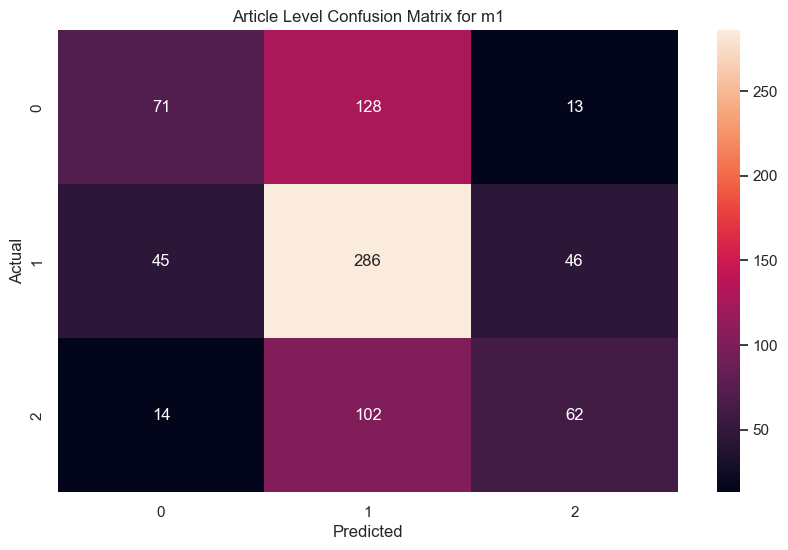

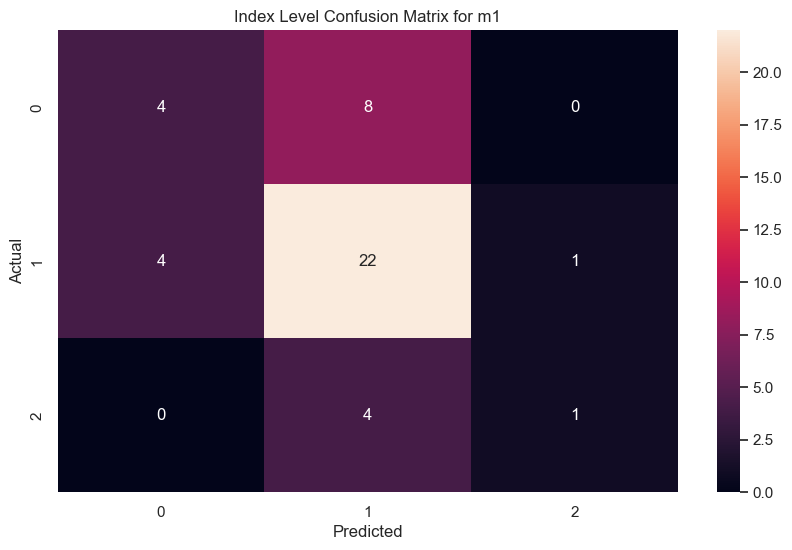

Article Level Results


,m1
accuracy,0.546
precision,0.538
recall,0.481
f1,0.490


Index Level Results


,m1
accuracy,0.614
precision,0.549
recall,0.449
f1,0.469


In [49]:
train_df_m1, test_df_m1 = prepare_setfit_datasets_m1(df_labelled, ['article_index', 'text', 'label'], 'm1')
train_evaluate_setfit_model(train_df_m1, test_df_m1, 'm1')

#### Model 2: SetFit with Text Features and Numerical Features concatenated as Text Features (Summary + Headline + Additional Features)

In [50]:
def prepare_setfit_datasets_m2(df_labelled, columns, method_name):
    df = df_labelled.copy()
    df = df[columns]

    df = df.groupby("article_index").filter(lambda x: len(x) > 1)

    df["text"] = (
        df["text"]
        + " There are "
        + df["mean_monthly_visits"].astype(str)
        + " mean monthly visitors to the website and "
        + df["mean_monthly_unique_visitors"].astype(str)
        + " mean monthly unique visitors to the website."
        
        # + " The article was published "
        # + df["hours_since_published"].astype(str)
        # + " hours after the last article of the same theme was published."
        # + " The article was published on the "
        # + df["day_of_week_published"].astype(str)
        # + " day of the week."
        # + " The article was published at the "
        # + df["hour_of_day_published"].astype(str)
        # + " hour of the day."
        # + " The headline has "
        # + df["text_non_stop_word_count"].astype(str)
        # + " non-stop words."
        # + " The text has a subjectivity score of "
        # + df["text_subjectivity"].astype(str)
        # + " and a sentiment score of "
        # + df["text_sentiment"].astype(str)
        # + "."
    )

    # split into train and test
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['article_index'])

    train_df.to_parquet(f'data/train_df_{method_name}.parquet')
    test_df.to_parquet(f'data/test_df_{method_name}.parquet')

    dataset = load_dataset("parquet", data_files={'train': f"data/train_df_{method_name}.parquet", 'test': f"data/test_df_{method_name}.parquet"})
    train_dataset = dataset["train"]
    test_dataset = dataset["test"]

    return train_dataset, test_dataset



Extracting data files: 100%|██████████| 2/2 [00:00<00:00, 1311.54it/s]


Dataset parquet downloaded and prepared to C:/Users/edmun/.cache/huggingface/datasets/parquet/default-39e5ce64af79de39/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


100%|██████████| 2/2 [00:00<00:00, 796.49it/s]
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset
Generating Training Pairs: 100%|██████████| 20/20 [00:01<00:00, 14.76it/s]
***** Running training *****
  Num examples = 122640
  Num epochs = 1
  Total optimization steps = 7665
  Total train batch size = 16
Epoch: 100%|██████████| 1/1 [17:31<00:00, 1051.48s/it]


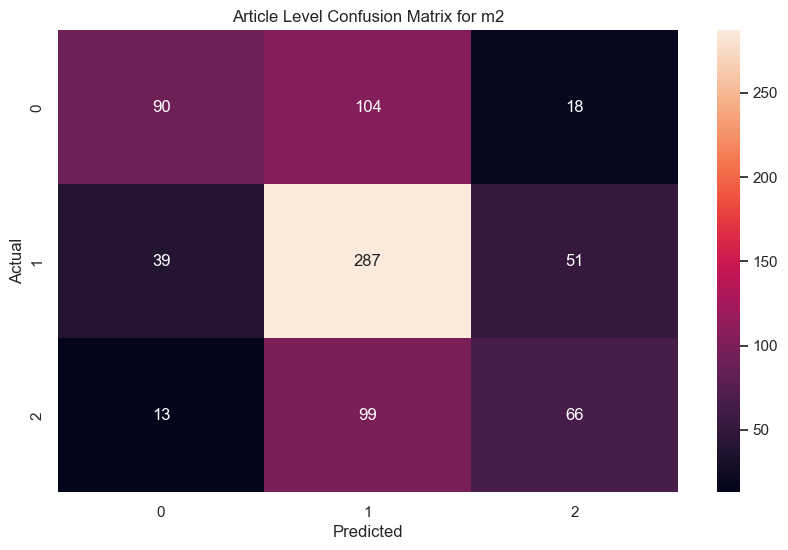

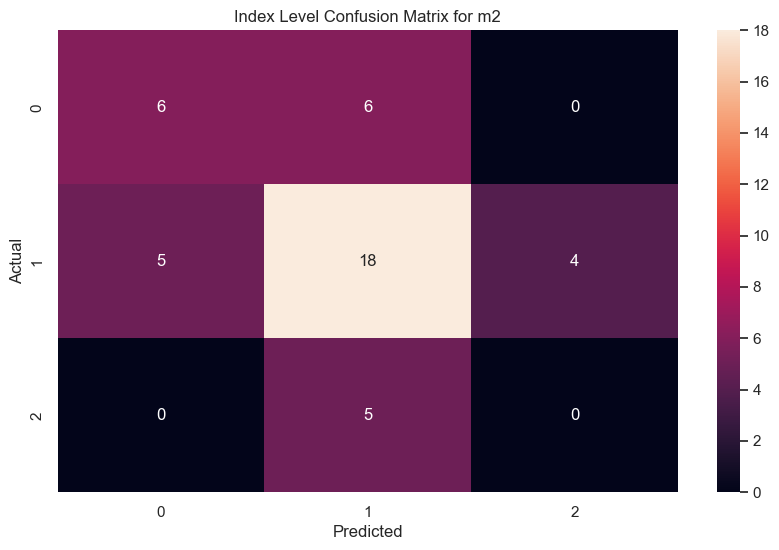

Article Level Results


,m1,m2
accuracy,0.546,0.578
precision,0.538,0.569
recall,0.481,0.519
f1,0.490,0.531


Index Level Results


,m1,m2
accuracy,0.614,0.545
precision,0.549,0.389
recall,0.449,0.389
f1,0.469,0.388


In [51]:
train_df_m2, test_df_m2 = prepare_setfit_datasets_m2(
    df_labelled,
    [
        "text",
        "mean_monthly_visits",
        "mean_monthly_unique_visitors",
        # "hours_since_published",
        # "day_of_week_published",
        # "hour_of_day_published",
        # "text_non_stop_word_count",
        # "text_subjectivity",
        # "text_sentiment",
        "article_index",
        "label",
    ],
    "m2",
)

train_evaluate_setfit_model(train_df_m2, test_df_m2, 'm2')


#### Model 2b:  SetFit with Text Features and Numerical Features concatenated as Text Features (Summary + Headline + Mean Monthly Visits + Mean Monthly Unqiue Visitors as bins)

In [52]:
def prepare_setfit_datasets_m2b(df_labelled, columns, method_name):
    df = df_labelled.copy()
    df = df[columns]

    df = df.groupby("article_index").filter(lambda x: len(x) > 1)
    
    # Normalise mean_monthly_visits and mean_monthly_unique_visitors
    df['mean_monthly_visits'] = df['mean_monthly_visits'] / df['mean_monthly_visits'].max()
    df['mean_monthly_unique_visitors'] = df['mean_monthly_unique_visitors'] / df['mean_monthly_unique_visitors'].max()

    # converting mean_monthly_visits and mean_monthly_unique_visitors to bin
    df['mean_monthly_visits'] = df['mean_monthly_visits'].apply(lambda x: "lowest" if x < 0.25 else ("low" if x < 0.5 else ("moderate" if x < 0.75 else "high")))
    df['mean_monthly_unique_visitors'] = df['mean_monthly_unique_visitors'].apply(lambda x: "lowest" if x < 0.25 else ("low" if x < 0.5 else ("moderate" if x < 0.75 else "high")))

    # # converting hours_since_published to bin
    # df['hours_since_published'] = df['hours_since_published'].apply(lambda x: "lowest" if x < 1 else ("low" if x < 2 else ("moderate" if x < 3 else "high")))

    # # converting text_non_stop_word_count to bin
    # df['text_non_stop_word_count'] = df['text_non_stop_word_count'].apply(lambda x: "lowest" if x < 5 else ("low" if x < 10 else ("moderate" if x < 15 else "high")))

    # # converting text_subjectivity to bin
    # df['text_subjectivity'] = df['text_subjectivity'].apply(lambda x: "lowest" if x < 0.25 else ("low" if x < 0.5 else ("moderate" if x < 0.75 else "high")))

    # # converting text_sentiment to bin
    # df['text_sentiment'] = df['text_sentiment'].apply(lambda x: "lowest" if x < -0.25 else ("low" if x < 0 else ("moderate" if x < 0.25 else "high")))

    # # convert day_of_week_published to day
    # df['day_of_week_published'] = df['day_of_week_published'].apply(lambda x: "Monday" if x == 0 else ("Tuesday" if x == 1 else ("Wednesday" if x == 2 else ("Thursday" if x == 3 else ("Friday" if x == 4 else ("Saturday" if x == 5 else "Sunday"))))))

    df["text"] = (
        df["text"]
        + " There are "
        + df["mean_monthly_visits"].astype(str)
        + " mean monthly visitors to the website and "
        + df["mean_monthly_unique_visitors"].astype(str)
        + " mean monthly unique visitors to the website."

        # + " The article was published "
        # + df["hours_since_published"].astype(str)
        # + " hours after the last article of the same theme was published."
        # + " The article was published on the "
        # + df["day_of_week_published"].astype(str)
        # + " day of the week."
        # + " The article was published at the "
        # + df["hour_of_day_published"].astype(str)
        # + " hour of the day."
        # + " The headline has "
        # + df["text_non_stop_word_count"].astype(str)
        # + " non-stop words."
        # + " The text has a subjectivity score of "
        # + df["text_subjectivity"].astype(str)
        # + " and a sentiment score of "
        # + df["text_sentiment"].astype(str)
        # + "."
    )

    # split into train and test
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['article_index'])

    train_df.to_parquet(f'data/train_df_{method_name}.parquet')
    test_df.to_parquet(f'data/test_df_{method_name}.parquet')

    dataset = load_dataset("parquet", data_files={'train': f"data/train_df_{method_name}.parquet", 'test': f"data/test_df_{method_name}.parquet"})
    train_dataset = dataset["train"]
    test_dataset = dataset["test"]

    return train_dataset, test_dataset



Extracting data files: 100%|██████████| 2/2 [00:00<00:00, 794.53it/s]


Dataset parquet downloaded and prepared to C:/Users/edmun/.cache/huggingface/datasets/parquet/default-b49aa639201da059/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


100%|██████████| 2/2 [00:00<00:00, 2003.49it/s]
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset
Generating Training Pairs: 100%|██████████| 20/20 [00:01<00:00, 13.64it/s]
***** Running training *****
  Num examples = 122640
  Num epochs = 1
  Total optimization steps = 7665
  Total train batch size = 16
Epoch: 100%|██████████| 1/1 [17:26<00:00, 1046.22s/it]


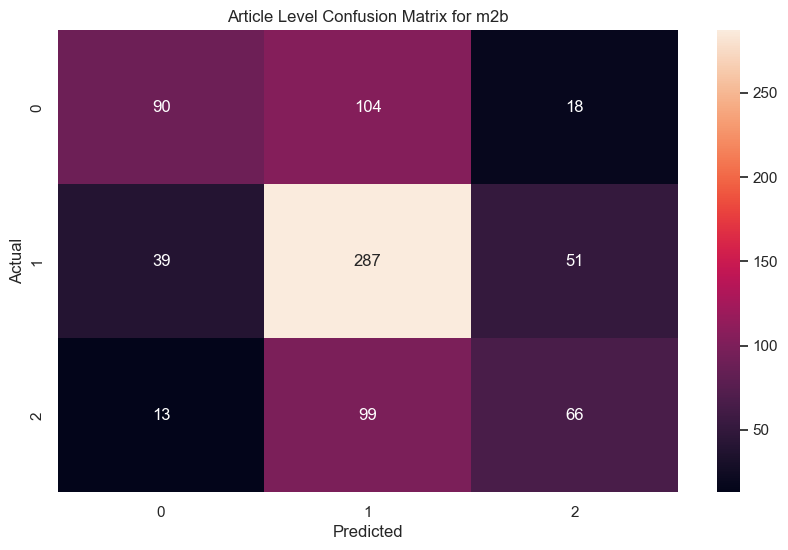

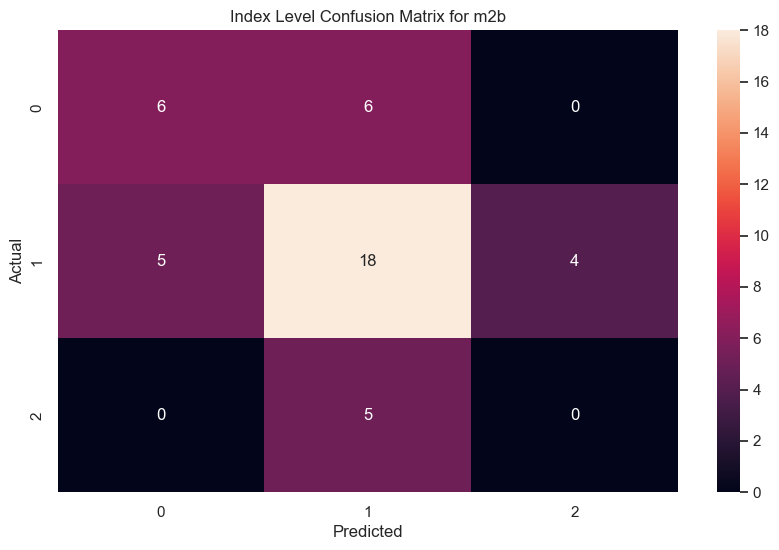

Article Level Results


,m1,m2,m2b
accuracy,0.546,0.578,0.578
precision,0.538,0.569,0.569
recall,0.481,0.519,0.519
f1,0.490,0.531,0.531


Index Level Results


,m1,m2,m2b
accuracy,0.614,0.545,0.545
precision,0.549,0.389,0.389
recall,0.449,0.389,0.389
f1,0.469,0.388,0.388


In [53]:
train_df_m2b, test_df_m2b = prepare_setfit_datasets_m2(
    df_labelled,
    [
        "text",
        "mean_monthly_visits",
        "mean_monthly_unique_visitors",
        # "hours_since_published",
        # "day_of_week_published",
        # "hour_of_day_published",
        # "text_non_stop_word_count",
        # "text_subjectivity",
        # "text_sentiment",
        "article_index",
        "label",
    ],
    "m2b",
)

train_evaluate_setfit_model(train_df_m2b, test_df_m2b, 'm2b')


#### Model 3: Combined models - Concat text embeddings with numerical features

In [54]:
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
from torch.optim import Adam

In [55]:
# Define the numeric model
class NumericModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NumericModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Define the final model
class FinalModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FinalModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.log_softmax(out)
        return out

# Define a custom dataset
class CustomDataset(Dataset):
    def __init__(self, dataframe, numeric_cols):
        self.dataframe = dataframe
        self.numeric_cols = numeric_cols

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        text = row['text']  
        numeric = torch.tensor(row[self.numeric_cols].apply(pd.to_numeric).values, dtype=torch.float)  
        label = torch.tensor(row['label'], dtype=torch.long) 
        return text, numeric, label


# Function for training
def train(dataloader, sentence_model, numeric_model, final_model, criterion, optimizer):
    final_model.train()
    numeric_model.train()
    sentence_model.train()

    total_loss = 0

    for batch in dataloader:
        # Separate the text, numeric, and label data
        text_data, numeric_data, labels = batch

        # Convert text to embeddings
        text_embeddings = sentence_model.encode(text_data)

        # Pass numeric data through our numeric model
        numeric_embeddings = numeric_model(numeric_data)

        # Concatenate text and numeric embeddings
        combined_embeddings = torch.cat((torch.tensor(text_embeddings), numeric_embeddings), dim=1)

        # Pass through the final model
        predictions = final_model(combined_embeddings)

        # Reshape predictions
        predictions = predictions.squeeze()

        # Compute loss
        loss = criterion(predictions, labels.long())
        total_loss += loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return total_loss / len(dataloader)

# Function for evaluation
def evaluate(dataloader, sentence_model, numeric_model, final_model, criterion):
    final_model.eval()
    numeric_model.eval()
    sentence_model.eval()
    
    total_loss = 0

    with torch.no_grad():
        for batch in dataloader:
            # Separate the text, numeric, and label data
            text_data, numeric_data, labels = batch

            # Convert text to embeddings
            text_embeddings = sentence_model.encode(text_data)

            # Pass numeric data through our numeric model
            numeric_embeddings = numeric_model(numeric_data)

            # Concatenate text and numeric embeddings
            combined_embeddings = torch.cat((torch.tensor(text_embeddings), numeric_embeddings), dim=1)

            # Pass through the final model
            predictions = final_model(combined_embeddings)

            # Reshape predictions
            predictions = predictions.squeeze()

            # Compute loss
            loss = criterion(predictions, labels.long())
            total_loss += loss.item()

    return total_loss / len(dataloader)



In [56]:
def prepare_concat_datasets_m3(df_labelled, columns):
    df = df_labelled.copy()
    df = df[columns]
    df = df.groupby("article_index").filter(lambda x: len(x) > 1)

    train_val_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['article_index'])
    train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=42, stratify=train_val_df['article_index'])

    scaler_mean_monthly_visit = MinMaxScaler()
    train_df[['mean_monthly_visits']] = scaler_mean_monthly_visit.fit_transform(train_df[['mean_monthly_visits']])

    # normalising mean_monthly_visits and mean_monthly_unique_visitors on val_df
    val_df[['mean_monthly_visits']] = scaler_mean_monthly_visit.transform(val_df[['mean_monthly_visits']])

    # normalising mean_monthly_visits and mean_monthly_unique_visitors on test_df
    test_df[['mean_monthly_visits']] = scaler_mean_monthly_visit.transform(test_df[['mean_monthly_visits']])

    scaler_mean_monthly_unique = MinMaxScaler()
    train_df[['mean_monthly_unique_visitors']] = scaler_mean_monthly_unique.fit_transform(train_df[['mean_monthly_unique_visitors']])

    # normalising mean_monthly_visits and mean_monthly_unique_visitors on val_df
    val_df[['mean_monthly_unique_visitors']] = scaler_mean_monthly_unique.transform(val_df[['mean_monthly_unique_visitors']])

    # normalising mean_monthly_visits and mean_monthly_unique_visitors on test_df
    test_df[['mean_monthly_unique_visitors']] = scaler_mean_monthly_unique.transform(test_df[['mean_monthly_unique_visitors']])

    # # normalising hours_since_published on train_df
    # scaler_hours = MinMaxScaler()
    # train_df[['hours_since_published']] = scaler_hours.fit_transform(train_df[['hours_since_published']])

    # # normalising hours_since_published on val_df
    # val_df[['hours_since_published']] = scaler_hours.transform(val_df[['hours_since_published']])

    # # normalising hours_since_published on test_df
    # test_df[['hours_since_published']] = scaler_hours.transform(test_df[['hours_since_published']])

    # # normalising text_non_stop_word_count on train_df
    # scaler_text = MinMaxScaler()
    # train_df[['text_non_stop_word_count']] = scaler_text.fit_transform(train_df[['text_non_stop_word_count']])

    # # normalising text_non_stop_word_count on val_df
    # val_df[['text_non_stop_word_count']] = scaler_text.transform(val_df[['text_non_stop_word_count']])

    # # normalising text_non_stop_word_count on test_df
    # test_df[['text_non_stop_word_count']] = scaler_text.transform(test_df[['text_non_stop_word_count']])

    return train_df, val_df, test_df

def prepare_dataloaders(train_df, val_df, test_df, numeric_columns, batch_size=32):
    # Create Datasets
    train_dataset = CustomDataset(train_df, numeric_columns)
    val_dataset = CustomDataset(val_df, numeric_columns)
    test_dataset = CustomDataset(test_df, numeric_columns)

    # Create DataLoaders
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_dataloader, val_dataloader, test_dataloader

def plot_loss_curves(train_losses, val_losses):
    plt.figure(figsize=(12, 8))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def train_model(train_dataloader, val_dataloader, numeric_columns):
    sentence_model = SentenceTransformer('all-MiniLM-L6-v2')

    # Instantiate NumericModel
    numeric_model = NumericModel(len(numeric_columns), 64, 512)  

    # Instantiate FinalModel
    final_model = FinalModel(896, 64, 3)

    # Define the criterion and the optimizer
    criterion = nn.NLLLoss()
    # criterion = nn.CrossEntropyLoss()
    optimizer = Adam(list(numeric_model.parameters()) + list(final_model.parameters()) + list(sentence_model.parameters()), lr=0.0001)

    N_EPOCHS = 100

    # Save train and validation losses

    train_losses = []
    val_losses = []

    # Train and evaluate the model
    for epoch in range(N_EPOCHS):  
        train_loss = train(train_dataloader, sentence_model, numeric_model, final_model, criterion, optimizer)
        valid_loss = evaluate(val_dataloader, sentence_model, numeric_model, final_model, criterion)
        train_losses.append(train_loss)
        val_losses.append(valid_loss)
        print(f'Epoch {epoch}: Train Loss: {train_loss}, Validation Loss: {valid_loss}')

        # early stopping
        if epoch > 30 and val_losses[epoch-1] < val_losses[epoch] and val_losses[epoch-2] < val_losses[epoch-1]:
            break

    plot_loss_curves(train_losses, val_losses)

    return final_model, sentence_model, numeric_model

def predict_model(final_model, sentence_model, numeric_model, test_dataloader):
    final_model.eval()  # Set the model to evaluation mode
    sentence_model.eval()
    numeric_model.eval()

    pred_y = []  # Initialize an empty list to store predictions

    with torch.no_grad():  # No need to calculate gradients for evaluation
        for texts, numerics, _ in test_dataloader:  # We don't care about labels here
            texts = [sentence_model.encode(text) for text in texts]
            texts = torch.tensor(texts, dtype=torch.float)
            numerics = numeric_model(numerics)
            inputs = torch.cat((texts, numerics), dim=1)
            log_outputs = final_model(inputs)
            outputs = torch.exp(log_outputs)  # Convert to probabilities
            _, predicted = torch.max(outputs.data, 1)  # Choose the class with the highest score
            pred_y.extend(predicted.tolist())  # Convert tensor to list and append to predictions

    pred_y = np.array(pred_y)

    return pred_y

def evaluate_model(test_df, pred_y, method_name):
    test_y = test_df['label'].values
    article_level_result = evaluate_predictions(test_y, pred_y).rename(columns={'macro': method_name})
    test_y_agg, pred_y_agg = get_predictions_agg(test_df, pred_y)
    index_level_result = evaluate_predictions(test_y_agg, pred_y_agg).rename(columns={'macro': method_name})

    if method_name not in RESULTS_STORE:
        RESULTS_STORE[method_name] = {'article_level': [], 'index_level': []}
    RESULTS_STORE[method_name]['article_level'] = article_level_result.to_dict()[method_name]
    RESULTS_STORE[method_name]['index_level'] = index_level_result.to_dict()[method_name]

    plot_confusion_matrix(test_y, pred_y, 'Article Level Confusion Matrix for ' + method_name)
    plot_confusion_matrix(test_y_agg, pred_y_agg, 'Index Level Confusion Matrix for ' + method_name)

    print('Article Level Results')
    display(display_results_store_article())
    print('Index Level Results')
    display(display_results_store_index())



Epoch 0: Train Loss: 1.0381564428279926, Validation Loss: 1.034897130727768
Epoch 1: Train Loss: 1.0247102317871986, Validation Loss: 1.031167697906494
Epoch 2: Train Loss: 1.019924584147218, Validation Loss: 1.0298064708709718
Epoch 3: Train Loss: 1.0174497900071082, Validation Loss: 1.0252965360879898
Epoch 4: Train Loss: 1.0130974990980965, Validation Loss: 1.0213144987821579
Epoch 5: Train Loss: 1.0093174452905531, Validation Loss: 1.0178558737039567
Epoch 6: Train Loss: 1.0045557471064779, Validation Loss: 1.0137926578521728
Epoch 7: Train Loss: 1.0012594763334695, Validation Loss: 1.0108401775360107
Epoch 8: Train Loss: 0.9962094875125141, Validation Loss: 1.007621705532074
Epoch 9: Train Loss: 0.9915981803621564, Validation Loss: 1.0045214593410492
Epoch 10: Train Loss: 0.9876671503116559, Validation Loss: 1.0018932431936265
Epoch 11: Train Loss: 0.9830266632042922, Validation Loss: 1.003524076938629
Epoch 12: Train Loss: 0.9800417872218342, Validation Loss: 0.9989066153764725
E

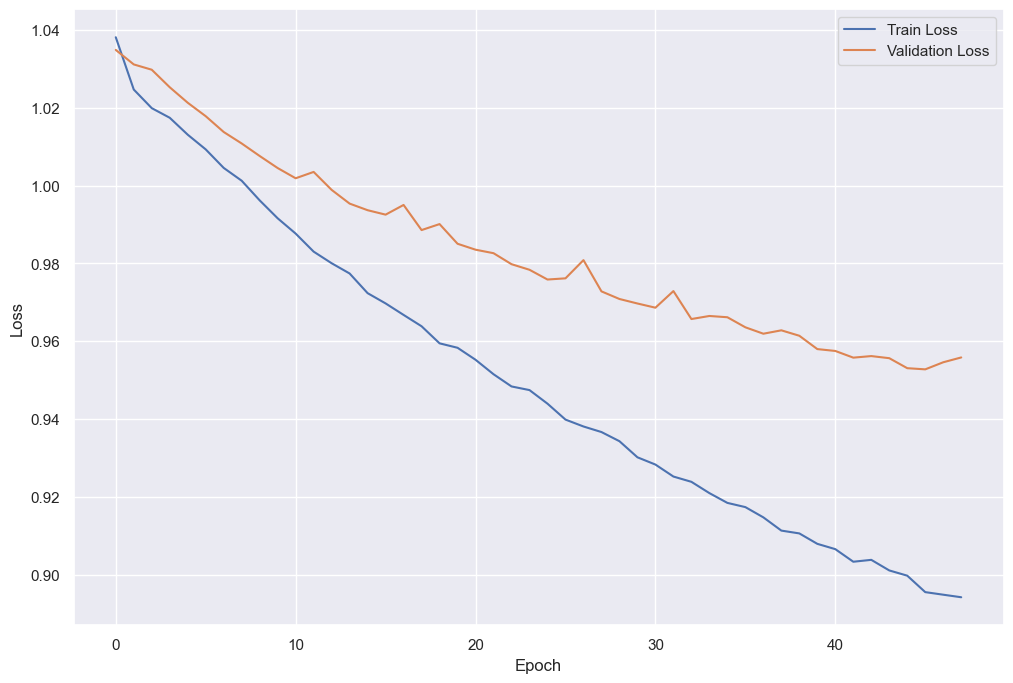

C:\Users\edmun\AppData\Local\Temp\ipykernel_11996\744370081.py:118: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:248.)
  texts = torch.tensor(texts, dtype=torch.float)
e:\Dropbox\Internships\GovTech\Codebase\news_matching\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


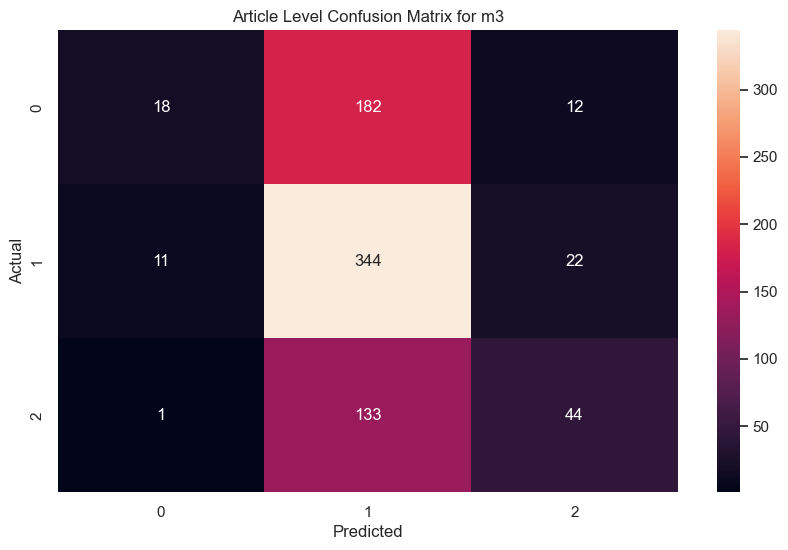

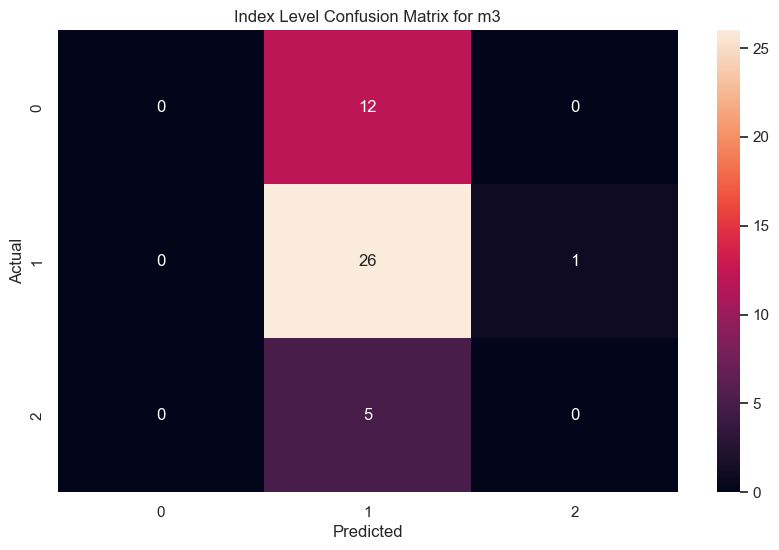

Article Level Results


,m1,m2,m2b,m3
accuracy,0.546,0.578,0.578,0.529
precision,0.538,0.569,0.569,0.562
recall,0.481,0.519,0.519,0.415
f1,0.490,0.531,0.531,0.386


Index Level Results


,m1,m2,m2b,m3
accuracy,0.614,0.545,0.545,0.591
precision,0.549,0.389,0.389,0.202
recall,0.449,0.389,0.389,0.321
f1,0.469,0.388,0.388,0.248


In [57]:
all_columns = [
    "text",
    "mean_monthly_visits",
    "mean_monthly_unique_visitors",
    # "hours_since_published",
    # "day_of_week_published",
    # "hour_of_day_published",
    # "text_non_stop_word_count",
    # "text_subjectivity",
    # "text_sentiment",
    "article_index",
    "label",
]

numeric_columns = [
    "mean_monthly_visits",
    "mean_monthly_unique_visitors",
    # "hours_since_published",
    # "day_of_week_published",
    # "hour_of_day_published",
    # "text_non_stop_word_count",
    # "text_subjectivity",
    # "text_sentiment",
]


train_df_m3, val_df_m3, test_df_m3 = prepare_concat_datasets_m3(
    df_labelled, all_columns
)

train_dataloader_m3, val_dataloader_m3, test_dataloader_m3 = prepare_dataloaders(
    train_df_m3, val_df_m3, test_df_m3, numeric_columns
)
final_model_m3, sentence_model_m3, numeric_model_m3 = train_model(
    train_dataloader_m3, val_dataloader_m3, numeric_columns
)
pred_y_m3 = predict_model(
    final_model_m3, sentence_model_m3, numeric_model_m3, test_dataloader_m3
)
evaluate_model(test_df_m3, pred_y_m3, "m3")

#### Model 3b:  Combined models - Concat text embeddings with numerical features (one hot encoding of domains only)

In [58]:
def prepare_concat_datasets_m3b(df_labelled, columns):
    df = df_labelled.copy()
    df = df[columns]
    df = df.groupby("article_index").filter(lambda x: len(x) > 1)

    df = pd.get_dummies(df, columns=['domain_group'])

    train_val_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['article_index'])
    train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=42, stratify=train_val_df['article_index'])

    scaler_mean_monthly_visit = MinMaxScaler()
    train_df[['mean_monthly_visits']] = scaler_mean_monthly_visit.fit_transform(train_df[['mean_monthly_visits']])

    # normalising mean_monthly_visits and mean_monthly_unique_visitors on val_df
    val_df[['mean_monthly_visits']] = scaler_mean_monthly_visit.transform(val_df[['mean_monthly_visits']])

    # normalising mean_monthly_visits and mean_monthly_unique_visitors on test_df
    test_df[['mean_monthly_visits']] = scaler_mean_monthly_visit.transform(test_df[['mean_monthly_visits']])

    scaler_mean_monthly_unique = MinMaxScaler()
    train_df[['mean_monthly_unique_visitors']] = scaler_mean_monthly_unique.fit_transform(train_df[['mean_monthly_unique_visitors']])

    # normalising mean_monthly_visits and mean_monthly_unique_visitors on val_df
    val_df[['mean_monthly_unique_visitors']] = scaler_mean_monthly_unique.transform(val_df[['mean_monthly_unique_visitors']])

    # normalising mean_monthly_visits and mean_monthly_unique_visitors on test_df
    test_df[['mean_monthly_unique_visitors']] = scaler_mean_monthly_unique.transform(test_df[['mean_monthly_unique_visitors']])

    # # normalising hours_since_published on train_df
    # scaler_hours = MinMaxScaler()
    # train_df[['hours_since_published']] = scaler_hours.fit_transform(train_df[['hours_since_published']])

    # # normalising hours_since_published on val_df
    # val_df[['hours_since_published']] = scaler_hours.transform(val_df[['hours_since_published']])

    # # normalising hours_since_published on test_df
    # test_df[['hours_since_published']] = scaler_hours.transform(test_df[['hours_since_published']])

    # # normalising text_non_stop_word_count on train_df
    # scaler_text = MinMaxScaler()
    # train_df[['text_non_stop_word_count']] = scaler_text.fit_transform(train_df[['text_non_stop_word_count']])

    # # normalising text_non_stop_word_count on val_df
    # val_df[['text_non_stop_word_count']] = scaler_text.transform(val_df[['text_non_stop_word_count']])

    # # normalising text_non_stop_word_count on test_df
    # test_df[['text_non_stop_word_count']] = scaler_text.transform(test_df[['text_non_stop_word_count']])

    return train_df, val_df, test_df

Epoch 0: Train Loss: 1.043645782130105, Validation Loss: 1.0275392085313797
Epoch 1: Train Loss: 1.0150908386552489, Validation Loss: 1.019888997077942
Epoch 2: Train Loss: 1.0025440090662474, Validation Loss: 1.0123127937316894
Epoch 3: Train Loss: 0.9898936562723928, Validation Loss: 1.0049177408218384
Epoch 4: Train Loss: 0.9799771649496896, Validation Loss: 0.9994042426347732
Epoch 5: Train Loss: 0.9699207613994549, Validation Loss: 0.9933011829853058
Epoch 6: Train Loss: 0.9631624608844905, Validation Loss: 0.9883496791124344
Epoch 7: Train Loss: 0.9588357248863617, Validation Loss: 0.9835810661315918
Epoch 8: Train Loss: 0.9521341803786042, Validation Loss: 0.9794854253530503
Epoch 9: Train Loss: 0.9477715554175439, Validation Loss: 0.9751275688409805
Epoch 10: Train Loss: 0.9422619366026544, Validation Loss: 0.9744130194187164
Epoch 11: Train Loss: 0.9383403488567897, Validation Loss: 0.9711627274751663
Epoch 12: Train Loss: 0.9375339297505169, Validation Loss: 0.967798730731010

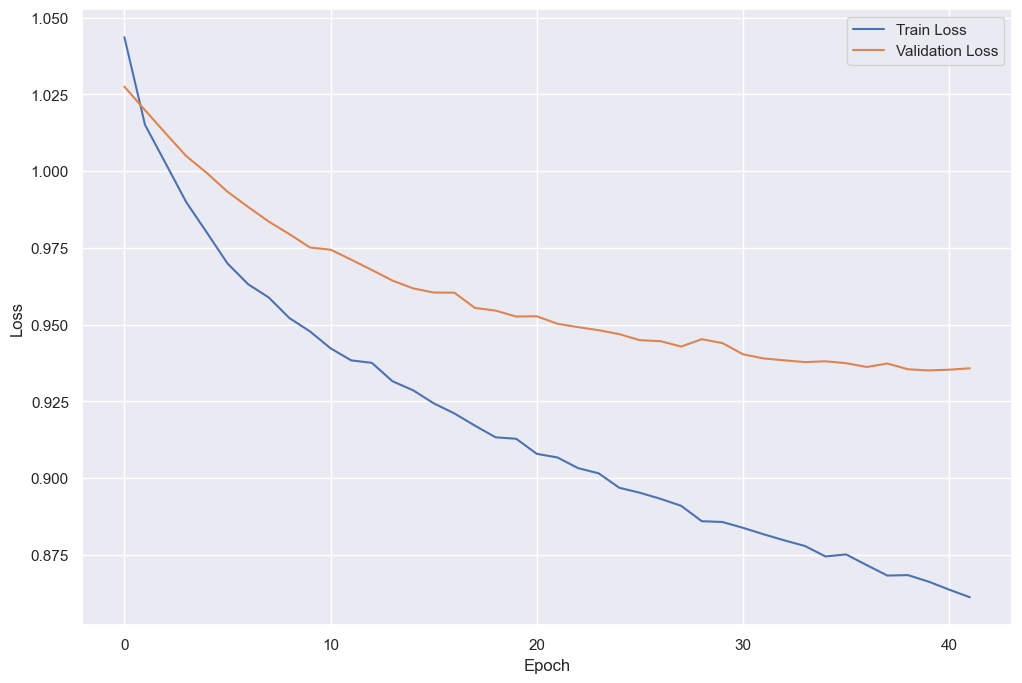

e:\Dropbox\Internships\GovTech\Codebase\news_matching\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


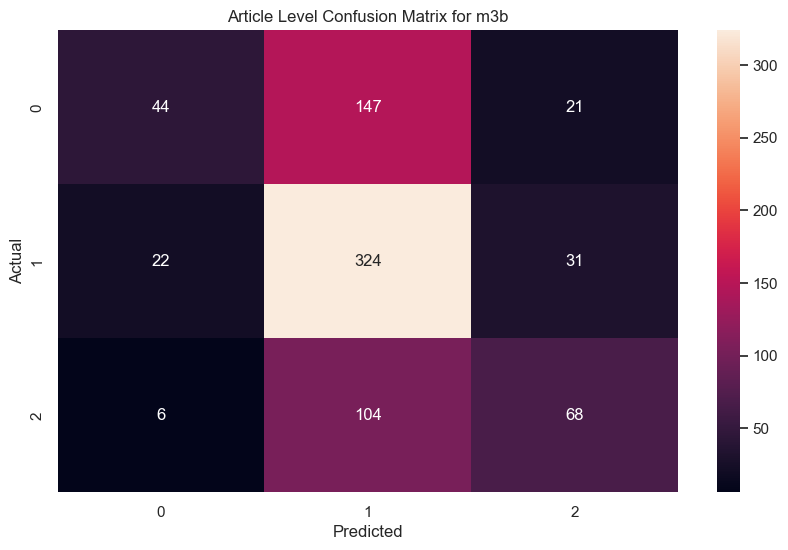

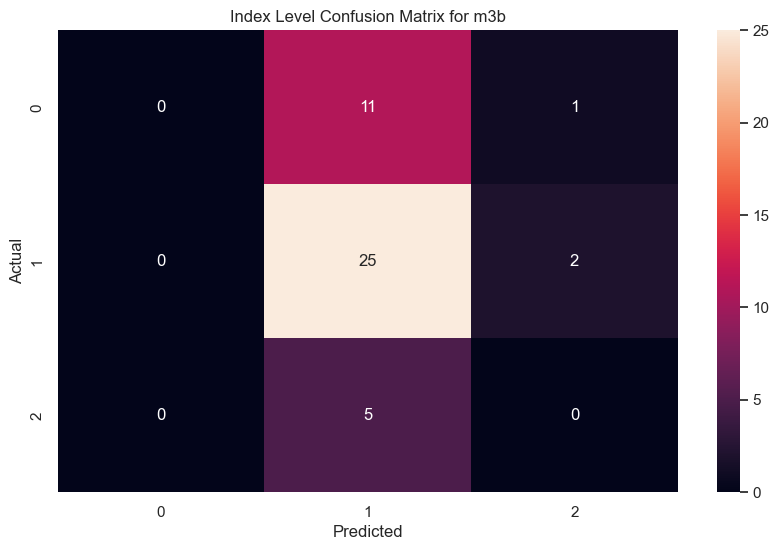

Article Level Results


,m1,m2,m2b,m3,m3b
accuracy,0.546,0.578,0.578,0.529,0.568
precision,0.538,0.569,0.569,0.562,0.580
recall,0.481,0.519,0.519,0.415,0.483
f1,0.490,0.531,0.531,0.386,0.482


Index Level Results


,m1,m2,m2b,m3,m3b
accuracy,0.614,0.545,0.545,0.591,0.568
precision,0.549,0.389,0.389,0.202,0.203
recall,0.449,0.389,0.389,0.321,0.309
f1,0.469,0.388,0.388,0.248,0.245


In [59]:
all_columns = [
    "text",
    'domain_group',
    "mean_monthly_visits",
    "mean_monthly_unique_visitors",
    # "hours_since_published",
    # "day_of_week_published",
    # "hour_of_day_published",
    # "text_non_stop_word_count",
    # "text_subjectivity",
    # "text_sentiment",
    "article_index",
    "label",
]

numeric_columns = [
    "mean_monthly_visits",
    "mean_monthly_unique_visitors",
    # "hours_since_published",
    # "day_of_week_published",
    # "hour_of_day_published",
    # "text_non_stop_word_count",
    # "text_subjectivity",
    # "text_sentiment",
]

train_df_m3b, val_df_m3b, test_df_m3b = prepare_concat_datasets_m3b(
    df_labelled, all_columns
)

domain_group_cols = [i for i in train_df_m3b.columns if "domain_group" in i]
numeric_columns = numeric_columns + domain_group_cols

train_dataloader_m3b, val_dataloader_m3b, test_dataloader_m3b = prepare_dataloaders(
    train_df_m3b, val_df_m3b, test_df_m3b, numeric_columns
)
final_model_m3b, sentence_model_m3b, numeric_model_m3b = train_model(
    train_dataloader_m3b, val_dataloader_m3b, numeric_columns
)
pred_y_m3b = predict_model(
    final_model_m3b, sentence_model_m3b, numeric_model_m3b, test_dataloader_m3b
)
evaluate_model(test_df_m3b, pred_y_m3b, "m3b")

#### Model 4: Multimodal Transformers

In [66]:
import pandas as pd
from multimodal_transformers.data import load_data
from transformers import AutoTokenizer
from multimodal_transformers.model import AutoModelWithTabular, TabularConfig
from transformers import AutoConfig
from transformers import Trainer, TrainingArguments


In [67]:
def prepare_multimodal_datasets_m4(df_labelled, all_columns, numerical_cols, method_name):
    df = df_labelled.copy()
    df = df[all_columns]
    df = df.groupby("article_index").filter(lambda x: len(x) > 1)
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['article_index'])

    scaler_mean_monthly_visit = MinMaxScaler()
    train_df[['mean_monthly_visits']] = scaler_mean_monthly_visit.fit_transform(train_df[['mean_monthly_visits']])
    test_df[['mean_monthly_visits']] = scaler_mean_monthly_visit.transform(test_df[['mean_monthly_visits']])

    scaler_mean_monthly_unique = MinMaxScaler()
    train_df[['mean_monthly_unique_visitors']] = scaler_mean_monthly_unique.fit_transform(train_df[['mean_monthly_unique_visitors']])
    test_df[['mean_monthly_unique_visitors']] = scaler_mean_monthly_unique.transform(test_df[['mean_monthly_unique_visitors']])

    # scaler_hours = MinMaxScaler()
    # train_df[['hours_since_published']] = scaler_hours.fit_transform(train_df[['hours_since_published']])
    # test_df[['hours_since_published']] = scaler_hours.transform(test_df[['hours_since_published']])

    # scaler_text = MinMaxScaler()
    # train_df[['text_non_stop_word_count']] = scaler_text.fit_transform(train_df[['text_non_stop_word_count']])
    # test_df[['text_non_stop_word_count']] = scaler_text.transform(test_df[['text_non_stop_word_count']])

    text_cols = ['text']
    label_col = 'label' 
    label_list = ['diminishing', 'neutral', 'trending']

    tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

    train_dataset = load_data(
        train_df,
        text_cols,
        tokenizer,
        numerical_cols=numerical_cols,
        label_col=label_col,
        sep_text_token_str=tokenizer.sep_token
    )

    test_dataset = load_data(
        test_df,
        text_cols,
        tokenizer,
        numerical_cols=numerical_cols,
        label_col=label_col,
        sep_text_token_str=tokenizer.sep_token
    )

    return train_dataset, test_dataset

def train_model(train_dataset, test_dataset):
    num_labels = 3
    config = AutoConfig.from_pretrained('bert-base-uncased')
    tabular_config = TabularConfig(
        num_labels=num_labels,
        numerical_feat_dim=train_dataset.numerical_feats.shape[1],
        combine_feat_method='weighted_feature_sum_on_transformer_cat_and_numerical_feats',
    )
    config.tabular_config = tabular_config

    model = AutoModelWithTabular.from_pretrained('bert-base-uncased', config=config)

    training_args = TrainingArguments(
        output_dir="./logs/model_name",
        logging_dir="./logs/runs",
        overwrite_output_dir=True,
        do_train=True,
        per_device_train_batch_size=32,
        num_train_epochs=5,
        # evaluate_during_training=True,
        logging_steps=25,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
    )

    trainer.train()

    return trainer


def evaluate_model(test_dataset, trainer, method_name):
    pred_y = trainer.predict(test_dataset)
    pred_y = pred_y.predictions[0].argmax(axis=1)
    test_y = test_dataset.df['label'].values
    
    article_level_result = evaluate_predictions(test_y, pred_y).rename(columns={'macro': method_name})
    test_y_agg, pred_y_agg = get_predictions_agg(test_dataset.df, pred_y)
    index_level_result = evaluate_predictions(test_y_agg, pred_y_agg).rename(columns={'macro': method_name})

    if method_name not in RESULTS_STORE:
        RESULTS_STORE[method_name] = {'article_level': [], 'index_level': []}
    RESULTS_STORE[method_name]['article_level'] = article_level_result.to_dict()[method_name]
    RESULTS_STORE[method_name]['index_level'] = index_level_result.to_dict()[method_name]

    plot_confusion_matrix(test_y, pred_y, 'Article Level Confusion Matrix for ' + method_name)
    plot_confusion_matrix(test_y_agg, pred_y_agg, 'Index Level Confusion Matrix for ' + method_name)

    print('Article Level Results')
    display(display_results_store_article())
    print('Index Level Results')
    display(display_results_store_index())

In [68]:
all_columns = [
    "text",
    "mean_monthly_visits",
    "mean_monthly_unique_visitors",
    # "hours_since_published",
    # "day_of_week_published",
    # "hour_of_day_published",
    # "text_non_stop_word_count",
    # "text_subjectivity",
    # "text_sentiment",
    "article_index",
    "label",
]

numerical_cols = [
    "mean_monthly_visits",
    "mean_monthly_unique_visitors",
    # "hours_since_published",
    # "day_of_week_published",
    # "hour_of_day_published"
    # "text_non_stop_word_count",
    # "text_subjectivity",
    # "text_sentiment",
]

train_dataset_m4, test_dataset_m4 = prepare_multimodal_datasets_m4(
    df_labelled, all_columns, numerical_cols, "m4"
)

trainer_m4 = train_model(train_dataset_m4, test_dataset_m4)

evaluate_model(test_dataset_m4, trainer_m4, 'm4')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertWithTabular: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertWithTabular from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertWithTabular from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertWithTabular were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['tabular_combiner.num_bn.running_var', 'tab

{'loss': 1.053, 'learning_rate': 4.739583333333333e-05, 'epoch': 0.26}


 10%|█         | 50/480 [32:02<2:43:28, 22.81s/it]

{'loss': 1.0292, 'learning_rate': 4.4791666666666673e-05, 'epoch': 0.52}


 16%|█▌        | 75/480 [41:30<2:33:17, 22.71s/it]

{'loss': 0.9644, 'learning_rate': 4.21875e-05, 'epoch': 0.78}


 21%|██        | 100/480 [50:54<2:22:14, 22.46s/it]

{'loss': 0.9455, 'learning_rate': 3.958333333333333e-05, 'epoch': 1.04}


 26%|██▌       | 125/480 [1:00:28<2:15:24, 22.89s/it]

{'loss': 0.8793, 'learning_rate': 3.697916666666667e-05, 'epoch': 1.3}


 31%|███▏      | 150/480 [1:09:55<2:04:20, 22.61s/it]

{'loss': 0.8456, 'learning_rate': 3.4375e-05, 'epoch': 1.56}


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:30                                                                                   │
│                                                                                                  │
│   27 │   df_labelled, all_columns, numerical_cols, "m4"                                          │
│   28 )                                                                                           │
│   29                                                                                             │
│ ❱ 30 trainer_m4 = train_model(train_dataset_m4, test_dataset_m4)                                 │
│   31                                                                                             │
│   32 evaluate_model(test_dataset_m4, trainer_m4, 'm4')                                           │
│   33                                                                                             │
│                                                                                                  │
│ in train_model:79                                                                                │
│                                                                                                  │
│    76 │   │   eval_dataset=test_dataset,                                                         │
│    77 │   )                                                                                      │
│    78 │                                                                                          │
│ ❱  79 │   trainer.train()                                                                        │
│    80 │                                                                                          │
│    81 │   return trainer                                                                         │
│    82                                                                                            │
│                                                                                                  │
│ e:\Dropbox\Internships\GovTech\Codebase\news_matching\venv\lib\site-packages\transformers\traine │
│ r.py:1645 in train                                                                               │
│                                                                                                  │
│   1642 │   │   inner_training_loop = find_executable_batch_size(                                 │
│   1643 │   │   │   self._inner_training_loop, self._train_batch_size, args.auto_find_batch_size  │
│   1644 │   │   )                                                                                 │
│ ❱ 1645 │   │   return inner_training_loop(                                                       │
│   1646 │   │   │   args=args,                                                                    │
│   1647 │   │   │   resume_from_checkpoint=resume_from_checkpoint,                                │
│   1648 │   │   │   trial=trial,                                                                  │
│                                                                                                  │
│ e:\Dropbox\Internships\GovTech\Codebase\news_matching\venv\lib\site-packages\transformers\traine │
│ r.py:1938 in _inner_training_loop                                                                │
│                                                                                                  │
│   1935 │   │   │   │   │   self.control = self.callback_handler.on_step_begin(args, self.state,  │
│   1936 │   │   │   │                                                                             │
│   1937 │   │   │   │   with self.accelerator.accumulate(model):                                  │
│ ❱ 1938 │   │   │   │   │   tr_loss_step = self.training_step(model, inputs)                      │
│   1939 │   │   │   │                                       

#### Model 4b. Multimodel Transformers with categorical domain encoding

In [ ]:
def prepare_multimodal_datasets_m4b(df_labelled, all_columns, numerical_cols, method_name):
    df = df_labelled.copy()
    df = df[all_columns]
    df = df.groupby("article_index").filter(lambda x: len(x) > 1)
    df = pd.get_dummies(df, columns=['domain_group'])

    domain_group_cols = [i for i in df.columns if "domain_group" in i]
    numerical_cols = numerical_cols + domain_group_cols

    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['article_index'])

    scaler_mean_monthly_visit = MinMaxScaler()
    train_df[['mean_monthly_visits']] = scaler_mean_monthly_visit.fit_transform(train_df[['mean_monthly_visits']])
    test_df[['mean_monthly_visits']] = scaler_mean_monthly_visit.transform(test_df[['mean_monthly_visits']])

    scaler_mean_monthly_unique = MinMaxScaler()
    train_df[['mean_monthly_unique_visitors']] = scaler_mean_monthly_unique.fit_transform(train_df[['mean_monthly_unique_visitors']])
    test_df[['mean_monthly_unique_visitors']] = scaler_mean_monthly_unique.transform(test_df[['mean_monthly_unique_visitors']])

    # scaler_hours = MinMaxScaler()
    # train_df[['hours_since_published']] = scaler_hours.fit_transform(train_df[['hours_since_published']])
    # test_df[['hours_since_published']] = scaler_hours.transform(test_df[['hours_since_published']])

    # scaler_text = MinMaxScaler()
    # train_df[['text_non_stop_word_count']] = scaler_text.fit_transform(train_df[['text_non_stop_word_count']])
    # test_df[['text_non_stop_word_count']] = scaler_text.transform(test_df[['text_non_stop_word_count']])

    text_cols = ['text']
    label_col = 'label' 
    label_list = ['diminishing', 'neutral', 'trending']

    tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

    train_dataset = load_data(
        train_df,
        text_cols,
        tokenizer,
        numerical_cols=numerical_cols,
        label_col=label_col,
        sep_text_token_str=tokenizer.sep_token
    )

    test_dataset = load_data(
        test_df,
        text_cols,
        tokenizer,
        numerical_cols=numerical_cols,
        label_col=label_col,
        sep_text_token_str=tokenizer.sep_token
    )

    return train_dataset, test_dataset

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertWithTabular: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertWithTabular from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertWithTabular from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertWithTabular were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['tabular_combiner.num_bn.running_var', 'tab

{'loss': 1.049, 'learning_rate': 4.791666666666667e-05, 'epoch': 0.21}


  8%|▊         | 50/600 [36:59<6:47:34, 44.46s/it]

{'loss': 1.0278, 'learning_rate': 4.5833333333333334e-05, 'epoch': 0.42}


 12%|█▎        | 75/600 [55:31<6:29:38, 44.53s/it]

{'loss': 0.9752, 'learning_rate': 4.375e-05, 'epoch': 0.62}


 17%|█▋        | 100/600 [1:14:03<6:10:28, 44.46s/it]

{'loss': 0.9628, 'learning_rate': 4.166666666666667e-05, 'epoch': 0.83}


 21%|██        | 125/600 [1:32:24<5:47:45, 43.93s/it]

{'loss': 0.951, 'learning_rate': 3.958333333333333e-05, 'epoch': 1.04}


 25%|██▌       | 150/600 [1:50:55<5:33:18, 44.44s/it]

{'loss': 0.8673, 'learning_rate': 3.7500000000000003e-05, 'epoch': 1.25}


 29%|██▉       | 175/600 [2:09:26<5:14:50, 44.45s/it]

{'loss': 0.8166, 'learning_rate': 3.541666666666667e-05, 'epoch': 1.46}


 33%|███▎      | 200/600 [2:27:57<4:56:29, 44.47s/it]

{'loss': 0.8262, 'learning_rate': 3.3333333333333335e-05, 'epoch': 1.67}


 38%|███▊      | 225/600 [2:46:29<4:37:48, 44.45s/it]

{'loss': 0.8136, 'learning_rate': 3.125e-05, 'epoch': 1.88}


 42%|████▏     | 250/600 [3:04:49<4:18:43, 44.35s/it]

{'loss': 0.7449, 'learning_rate': 2.916666666666667e-05, 'epoch': 2.08}


 46%|████▌     | 275/600 [3:23:20<4:00:42, 44.44s/it]

{'loss': 0.5992, 'learning_rate': 2.7083333333333332e-05, 'epoch': 2.29}


 50%|█████     | 300/600 [3:41:51<3:42:09, 44.43s/it]

{'loss': 0.5541, 'learning_rate': 2.5e-05, 'epoch': 2.5}


 54%|█████▍    | 325/600 [4:00:22<3:23:47, 44.46s/it]

{'loss': 0.5498, 'learning_rate': 2.2916666666666667e-05, 'epoch': 2.71}


 58%|█████▊    | 350/600 [4:18:54<3:05:10, 44.44s/it]

{'loss': 0.5599, 'learning_rate': 2.0833333333333336e-05, 'epoch': 2.92}


 62%|██████▎   | 375/600 [4:37:14<2:46:40, 44.45s/it]

{'loss': 0.4256, 'learning_rate': 1.8750000000000002e-05, 'epoch': 3.12}


 67%|██████▋   | 400/600 [4:55:45<2:28:07, 44.44s/it]

{'loss': 0.3471, 'learning_rate': 1.6666666666666667e-05, 'epoch': 3.33}


 71%|███████   | 425/600 [5:14:16<2:09:40, 44.46s/it]

{'loss': 0.3274, 'learning_rate': 1.4583333333333335e-05, 'epoch': 3.54}


 75%|███████▌  | 450/600 [5:32:47<1:51:06, 44.44s/it]

{'loss': 0.3178, 'learning_rate': 1.25e-05, 'epoch': 3.75}


 79%|███████▉  | 475/600 [5:51:18<1:32:34, 44.44s/it]

{'loss': 0.3361, 'learning_rate': 1.0416666666666668e-05, 'epoch': 3.96}


 83%|████████▎ | 500/600 [6:09:39<1:14:19, 44.60s/it]

{'loss': 0.2019, 'learning_rate': 8.333333333333334e-06, 'epoch': 4.17}


 88%|████████▊ | 525/600 [6:28:13<55:35, 44.47s/it]  

{'loss': 0.2156, 'learning_rate': 6.25e-06, 'epoch': 4.38}


 92%|█████████▏| 550/600 [6:46:47<37:18, 44.77s/it]

{'loss': 0.1868, 'learning_rate': 4.166666666666667e-06, 'epoch': 4.58}


 96%|█████████▌| 575/600 [7:00:50<13:34, 32.58s/it]

{'loss': 0.1915, 'learning_rate': 2.0833333333333334e-06, 'epoch': 4.79}


100%|██████████| 600/600 [7:14:12<00:00, 43.42s/it]


{'loss': 0.1731, 'learning_rate': 0.0, 'epoch': 5.0}
{'train_runtime': 26052.0862, 'train_samples_per_second': 0.736, 'train_steps_per_second': 0.023, 'train_loss': 0.5841869497299195, 'epoch': 5.0}


100%|██████████| 96/96 [01:52<00:00,  1.17s/it]


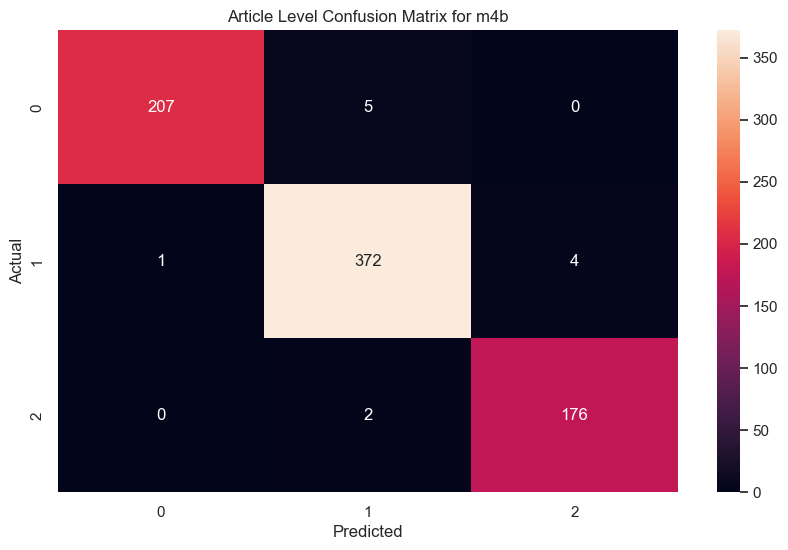

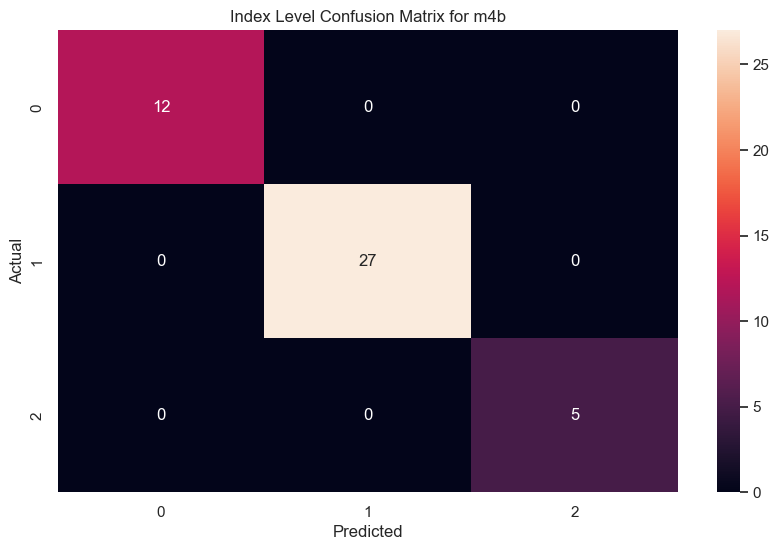

Article Level Results


,m1,m2,m2b,m3,m3b,m4,m4b
accuracy,0.546,0.578,0.578,0.529,0.568,0.980,0.984
precision,0.538,0.569,0.569,0.562,0.580,0.980,0.985
recall,0.481,0.519,0.519,0.415,0.483,0.979,0.984
f1,0.490,0.531,0.531,0.386,0.482,0.979,0.984


Index Level Results


,m1,m2,m2b,m3,m3b,m4,m4b
accuracy,0.614,0.545,0.545,0.591,0.568,0.955,1.0
precision,0.549,0.389,0.389,0.202,0.203,0.917,1.0
recall,0.449,0.389,0.389,0.321,0.309,0.960,1.0
f1,0.469,0.388,0.388,0.248,0.245,0.936,1.0


In [ ]:
all_columns = [
    "text",
    "domain_group",
    "mean_monthly_visits",
    "mean_monthly_unique_visitors",
    # "hours_since_published",
    # "day_of_week_published",
    # "hour_of_day_published",
    # "text_non_stop_word_count",
    # "text_subjectivity",
    # "text_sentiment",
    "article_index",
    "label",
]

numerical_cols = [
    "mean_monthly_visits",
    "mean_monthly_unique_visitors",
    # "hours_since_published",
    # "day_of_week_published",
    # "hour_of_day_published"
    # "text_non_stop_word_count",
    # "text_subjectivity",
    # "text_sentiment",
]

train_dataset_m4b, test_dataset_m4b = prepare_multimodal_datasets_m4b(
    df_labelled, all_columns, numerical_cols, "m4b"
)

trainer_m4b = train_model(train_dataset_m4b, test_dataset_m4b)

evaluate_model(test_dataset_m4b, trainer_m4b, 'm4b')




In [ ]:
df_unique

,published,headline,summary,link,domain,facebook_interactions,date_extracted,article_theme,article_index,text,...,text_unique_word_count,headline_sentiment,summary_sentiment,text_sentiment,headline_subjectivity,summary_subjectivity,text_subjectivity,domain_group,mean_monthly_visits,mean_monthly_unique_visitors
0,2023-06-01 06:40:01,â€˜Why is your client smiling?' Judge asks lawyer of voyeur who filmed women nearly 100 times,"Darren Yeo Wei Hong used a hidden camera disguised as a smoke detector to film at least 5 women, including his own friends.",https://www.facebook.com/129011692114_10159241129327115,straitstimes.com,696,2023-06-02,general,others,"â€˜Why is your client smiling?' Judge asks lawyer of voyeur who filmed women nearly 100 times Darren Yeo Wei Hong used a hidden camera disguised as a smoke detector to film at least 5 women, including his own friends.",...,38,0.100,0.044444,0.058333,0.400000,0.577778,0.533333,straitstimes,12310000,2230000
1,2023-05-01 03:07:55,"â€˜We will always have your back': 4G team will look after workers in these dark times, says DPM Wong","""As we grow the economy, we will also fight the ills of inequality,"" said Mr Wong at the May Day Rally on Monday where he was the main speaker.\n\nGet alerts on Telegram: https://t.me/TheStraitsTimes",https://www.facebook.com/129011692114_10159181582487115,straitstimes.com,360,2023-05-02,jobs and economy,others,"â€˜We will always have your back': 4G team will look after workers in these dark times, says DPM Wong ""As we grow the economy, we will also fight the ills of inequality,"" said Mr Wong at the May Day Rally on Monday where he was the main speaker.\n\nGet alerts on Telegram: https://t.me/TheStraitsTimes",...,45,-0.075,0.166667,0.005556,0.200000,0.333333,0.244444,straitstimes,12310000,2230000
2,2023-05-31 02:02:39,â€˜We cannot stop covering Chinaâ€™ despite challenges faced: journalists at N3Con 2023,"One needs to be ""creative, resourceful, innovative"" in covering China from outside the country, said one of the journalists.",https://www.facebook.com/592308557475467_6684972978208964,mothership.sg,18,2023-06-01,foreign affairs,others,"â€˜We cannot stop covering Chinaâ€™ despite challenges faced: journalists at N3Con 2023 One needs to be ""creative, resourceful, innovative"" in covering China from outside the country, said one of the journalists.",...,29,0.000,0.400000,0.400000,0.000000,0.737500,0.737500,mothership,6770000,1660000
3,2023-05-27 00:00:09,â€˜Wang hong' culture booms in China as more young people dream of becoming influencers,"Chinaâ€™s influencer economy is set to hit S$1.3 trillion by 2025, up more than 5 times from 2020.",https://www.facebook.com/129011692114_10159229995092115,straitstimes.com,3355,2023-06-02,foreign affairs,others,"â€˜Wang hong' culture booms in China as more young people dream of becoming influencers Chinaâ€™s influencer economy is set to hit S$1.3 trillion by 2025, up more than 5 times from 2020.",...,31,0.350,0.500000,0.387500,0.583333,0.500000,0.562500,straitstimes,12310000,2230000
4,2023-06-11 12:00:14,â€˜There will never be another You': Wife of missing Everest climber in tribute post,"â€œThrough him, I realised Singapore was more than just a glitzy concrete jungle. He opened my eyes to her rainforests and waterways that were hidden from plain sight,"" Madam Sushma Soma said in the post.",https://www.facebook.com/129011692114_568506245436540,straitstimes.com,823,2023-06-12,natural disasters,landslide,"â€˜There will never be another You': Wife of missing Everest climber in tribute post â€œThrough him, I realised Singapore was more than just a glitzy concrete jungle. He opened my eyes to her rainforests and waterways that were hidden from plain sight,"" Madam Sushma Soma said in the post.",...,48,-0.200,0.067262,0.013810,0.050000,0.372619,0.308095,straitstimes,12310000,2230000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3829,2023-05-15 10:02:01,"#trending: Blackpink fa